# Test Concepts

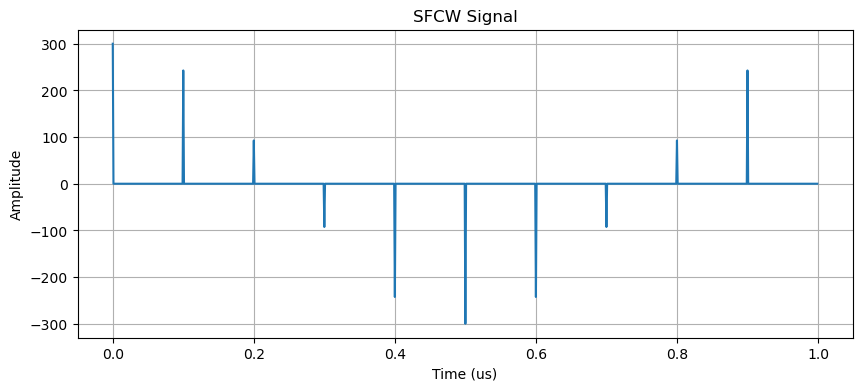

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
start_freq = 1e6   # Starting frequency in Hz
freq_step = 1e7    # Frequency step size in Hz
chirp_duration = 1e-6  # Chirp duration in seconds
sampling_rate = 1e9  # Sampling rate in Hz
num_steps = 300      # Number of frequency steps

# Time vector
time = np.arange(0, chirp_duration, 1/sampling_rate)

# Generate SFCW signal
sfcw_signal = np.zeros(len(time), dtype=complex)
for step in range(num_steps):
    freq = start_freq + step * freq_step
    chirp = np.exp(2j * np.pi * freq * time)
    sfcw_signal += chirp

# Plot the SFCW signal
plt.figure(figsize=(10, 4))
plt.plot(time * 1e6, np.real(sfcw_signal))
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.title('SFCW Signal')
plt.grid()
plt.show()


In [2]:
import os
import numpy as np
from PIL import Image

# Path to the folder containing PNG images
folder_path = "C:\\Users\\thanh\\OneDrive\\Documents\\FYP\\FieldTest\\Pine"

# Get a list of all PNG files in the folder
png_files = [file for file in os.listdir(folder_path) if file.lower().endswith(".png")]

# Sort the file list to maintain order
png_files.sort()

# Load each image, convert it to a 2D NumPy array, and store in a list
image_arrays = []
for file in png_files:
    image_path = os.path.join(folder_path, file)
    image = Image.open(image_path)
    image_array = np.array(image)
    image_arrays.append(image_array)

# Convert the list of arrays to a 3D NumPy array
image_stack = np.stack(image_arrays, axis=0)

# Print the shape of the resulting 3D array
print("Shape of the resulting 3D array:", image_stack.shape)


Shape of the resulting 3D array: (103, 88, 73)


In [4]:
import k3d
import numpy as np
# plt_volume = k3d.volume(CT_scan_3D)
plt_volume = k3d.volume(image_stack)

plot = k3d.plot()
plot.grid_visible = False
plot += plt_volume
plot.display()

c:\Users\thanh\miniconda3\envs\gprMax\Lib\site-packages\k3d\objects.py:1328: UserWarning: wrong dtype: bool ([<class 'numpy.float16'>, <class 'numpy.float32'>] required)
  warnings.warn("wrong dtype: %s (%s required)" % (actual, required))


Output()

In [3]:
import h5py
filename = 'geometry_stl.h5'
# Create a dataset within the 'data' group and store the array
with h5py.File(filename, 'w') as file:
    dset = file.create_dataset("data", data=image_stack)

    # Add a root attribute with the name 'dx_dy_dz'
    file.attrs['dx_dy_dz'] = (0.002, 0.002, 0.002)


## Real Data

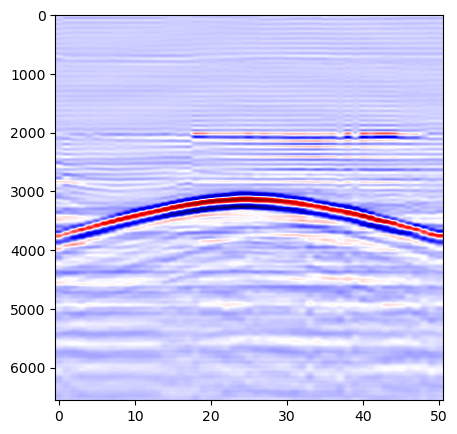

In [29]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

mat = scipy.io.loadmat('geometry_data.mat')
data = np.array(mat['S11_ra'])

# Set the desired width and height of the figure
fig_width = 5
fig_height = 5

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(data, cmap='seismic', aspect='auto')

# Display the plot
plt.show()

In [34]:
from skimage.transform import resize

image = resize(data, (200,200))

image = image - np.min(image)
image = image/ np.max(image)
image = image * 225
image = np.round(image).astype(np.uint8)

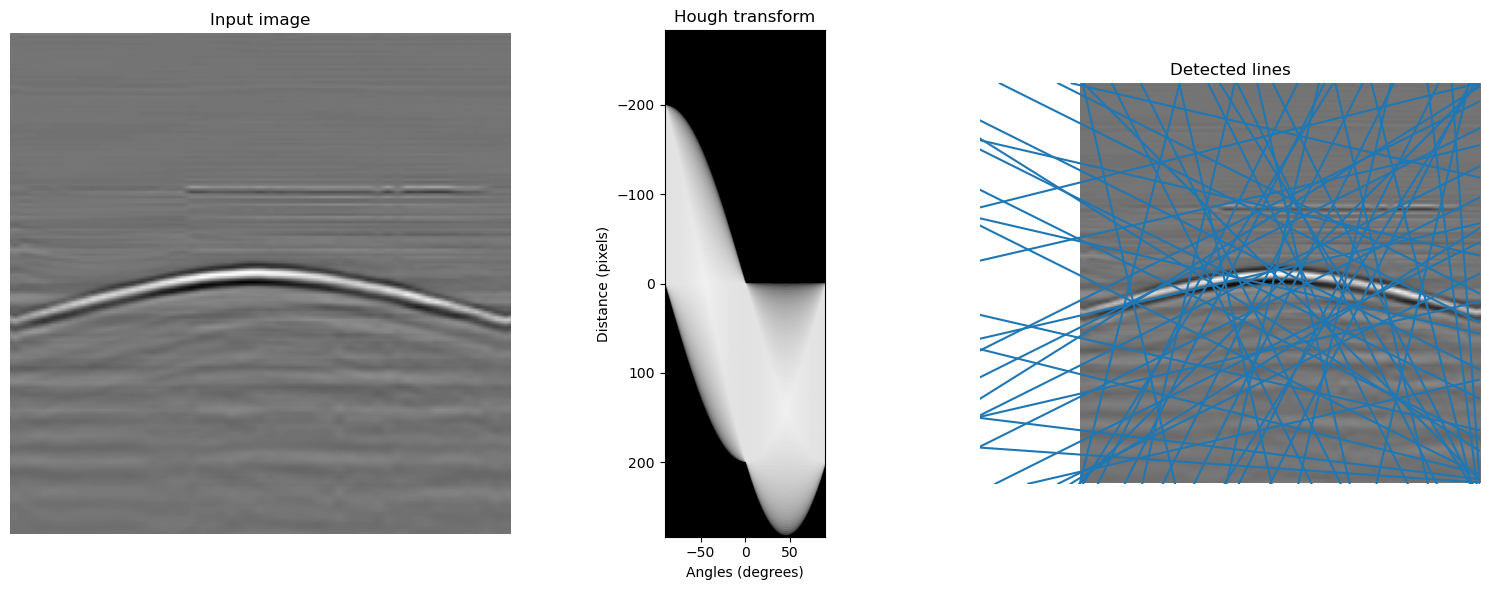

In [35]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
# from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm


# # Constructing test image
# image = np.zeros((200, 200))
# idx = np.arange(25, 175)
# image[idx, idx] = 255
# image[draw_line(45, 25, 25, 175)] = 255
# image[draw_line(25, 135, 175, 155)] = 255

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.tight_layout()
plt.show()

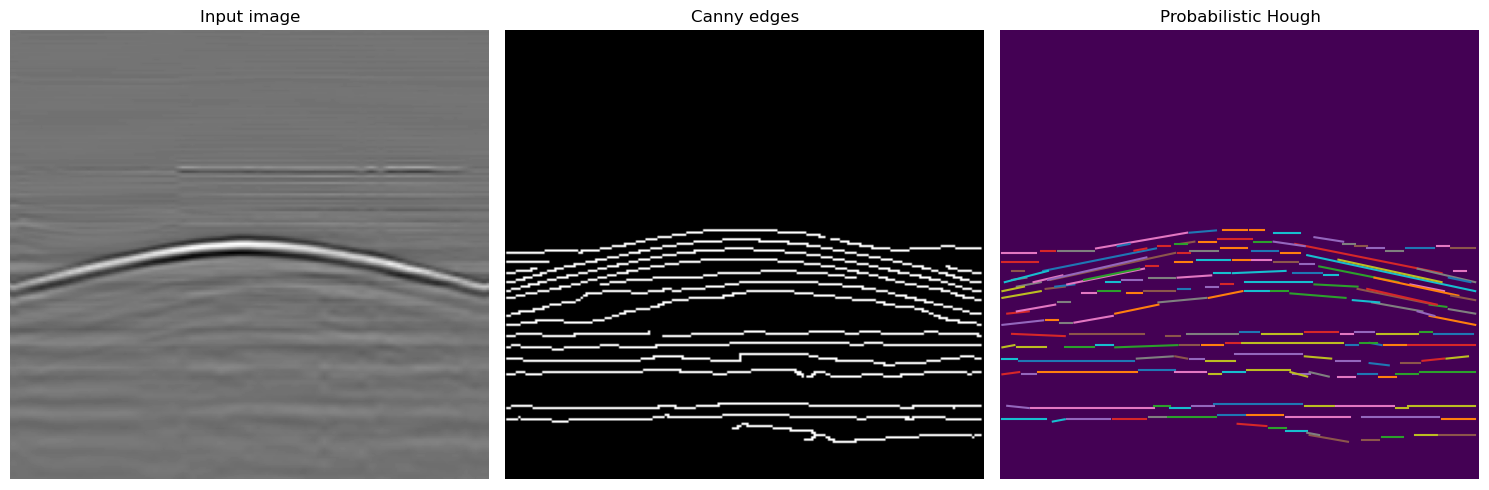

In [36]:
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform
# image = data.camera()
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray, aspect = 'auto')
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray, aspect = 'auto')
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0, aspect = 'auto')
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
# Create a single figure and axis
fig, ax = plt.subplots(nrows = 2, figsize=(8, 4))

for i in range(2):
    # Plot the three arrays as separate lines
    ax[i].plot(range(len(data)), data[:,int((len(data[0,:]))/2)*i].flatten(), label='Power', lw=3)

# Show the plot
plt.show()

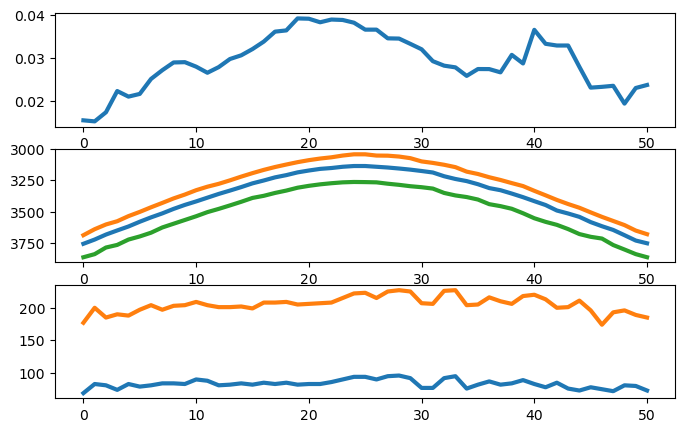

In [354]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelmin

# Assuming you have already loaded the 'data' array

# Find the global maximum for each column
max_values = np.max(data, axis=0)
max_indices = np.argmax(data, axis=0)
local_min1 = []
local_min2 = []
# Create a single figure and axis
fig, ax = plt.subplots(nrows=3, figsize=(8, 5))

# Plot the global maximum values
ax[0].plot(range(len(max_values)), max_values, label='Ez', lw=3)

# Find and plot local minima for each global maximum
for i, idx in enumerate(max_indices):
    # Find the indices of local minima around the current maximum
    local_minima_indices = argrelmin(data[:, i], order=10)[0]

    # Find the two closest local minima
    closest_minima_indices = np.argsort(np.abs(local_minima_indices - idx))[:2]
    closest_minima = local_minima_indices[closest_minima_indices]

    local_min1.append(closest_minima[0])
    local_min2.append(closest_minima[1])
local_min1 = np.array(local_min1)
local_min2 = np.array(local_min2)
# Plot the global maximum indices with inverted y-axis
ax[1].plot(range(len(max_indices)), max_indices, label='Ez', lw=3)
ax[1].plot(range(len(local_min1)), local_min1, label='Ez', lw=3)
ax[1].plot(range(len(local_min2)), local_min2, label='Ez', lw=3)
ax[1].invert_yaxis()

ax[2].plot(range(len(max_indices)), max_indices - local_min1, label='Ez', lw=3)
ax[2].plot(range(len(max_indices)), local_min2 - local_min1, label='Ez', lw=3)
plt.show()


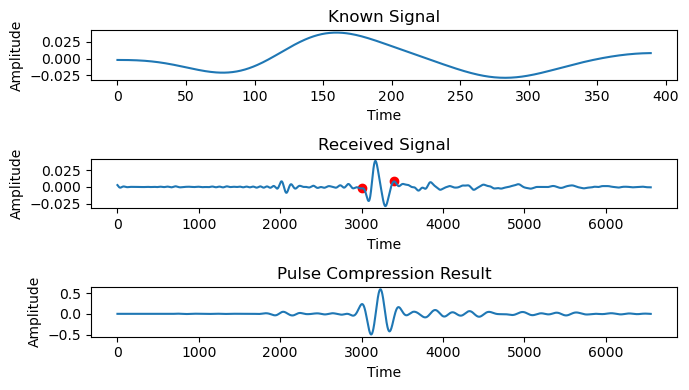

In [360]:
import numpy as np
import matplotlib.pyplot as plt
# Pulse Compression
scan_idx = 20
signal_idx = data[:,scan_idx].flatten()
param_idx = [local_min1[scan_idx], max_indices[scan_idx], local_min2[scan_idx]]
start_filter = param_idx[0]
while signal_idx[start_filter] < signal_idx[start_filter - 1]:
    start_filter = start_filter - 1
end_filter = param_idx[2]
while signal_idx[end_filter] < signal_idx[end_filter + 1]:
    end_filter = end_filter + 1
filter_idx = signal_idx[start_filter: end_filter]


# Define the known signal and received signal
known_signal = filter_idx
received_signal = signal_idx


# Perform pulse compression
compressed_signal = np.convolve(received_signal, known_signal[::-1], mode='same')
compressed_signal = np.convolve(compressed_signal, known_signal[::-1], mode='same')
# Plotting the signals
plt.figure(figsize=(7, 4))

# Plot the known signal
plt.subplot(3, 1, 1)
plt.plot(known_signal)
plt.title('Known Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the received signal
plt.subplot(3, 1, 2)
plt.plot(received_signal)
plt.scatter(start_filter,received_signal[start_filter], color = 'red')
plt.scatter(end_filter,received_signal[end_filter], color = 'red')
plt.title('Received Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the pulse compression result
plt.subplot(3, 1, 3)
plt.plot(compressed_signal)
plt.title('Pulse Compression Result')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


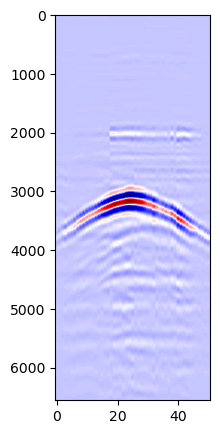

In [361]:
# Pulse Compression
PC_list = []
for scan_idx in range(51):
    signal_idx = data[:,scan_idx].flatten()
    param_idx = [local_min1[scan_idx], max_indices[scan_idx], local_min2[scan_idx]]
    start_filter = param_idx[0]
    # while signal_idx[start_filter] < signal_idx[start_filter - 1]:
    #     start_filter = start_filter - 1
    end_filter = param_idx[2]
    # while signal_idx[end_filter] < signal_idx[end_filter + 1]:
    #     end_filter = end_filter + 1
    filter_idx = signal_idx[start_filter: end_filter]
    
    # Define the known signal and received signal
    known_signal = filter_idx
    received_signal = signal_idx

    # Perform pulse compression
    compressed_signal = np.convolve(received_signal, known_signal[::-1], mode='same')
    compressed_signal = np.convolve(compressed_signal, known_signal[::-1], mode='same')


    PC_list.append(compressed_signal)

# Set the desired width and height of the figure
fig_width = 2
fig_height = 5
# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(np.transpose(PC_list), cmap='seismic', aspect='auto')

# Display the plot
plt.show()

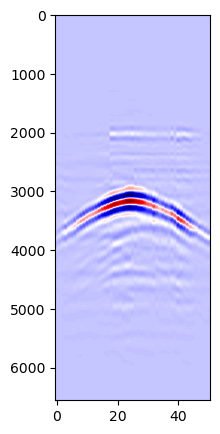

In [362]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows
bscan_data = np.array(np.transpose(PC_list))
# Assuming you have the B-scan data as 'bscan_data' with shape (6556, 51)

# Apply windowing to reduce ringing artifacts
window = windows.hann(bscan_data.shape[0])[:, np.newaxis]
bscan_data_windowed = bscan_data * window

# Set the desired width and height of the figure
fig_width = 2
fig_height = 5
# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(bscan_data_windowed, cmap='seismic', aspect='auto')

# Display the plot
plt.show()

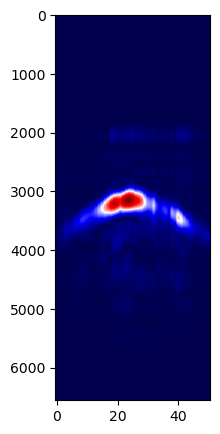

In [363]:
bscan = np.copy(bscan_data_windowed)
from scipy.signal import hilbert

# Perform 2D Hilbert transform column-wise
hilbert_transform = np.apply_along_axis(hilbert, axis=0, arr=bscan)

# Extract envelope and phase information
envelope = np.abs(hilbert_transform)
phase = np.angle(hilbert_transform)
    
# Set the desired width and height of the figure
fig_width = 2
fig_height = 5

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(envelope, cmap='seismic', aspect='auto')
# Display the plot
plt.show()

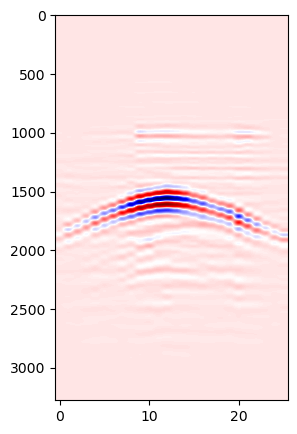

In [365]:
import numpy as np
import pywt
coeffs = pywt.dwt2(bscan_data_windowed, 'haar')
cA, (cH, cV, cD) = coeffs
cD.shape

# Set the desired width and height of the figure
fig_width = 3
fig_height = 5

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(cH, cmap='seismic', aspect='auto')
# Display the plot
plt.show()

In [10]:
mat_dict = {"local min 1": local_min1, "local min 2": local_min2, "global max": max_indices, "Matched Filter x 2": bscan_data, "Hann Window": bscan_data_windowed}

from scipy.io import savemat
savemat("geometry_data_Matched_Filter.mat", mat_dict)

In [12]:
from scipy.io import loadmat
test = loadmat("geometry_data_Matched_Filter.mat")
test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'local min 1', 'local min 2', 'global max', 'Matched Filter x 2', 'Hann Window'])

2.6682363800411992


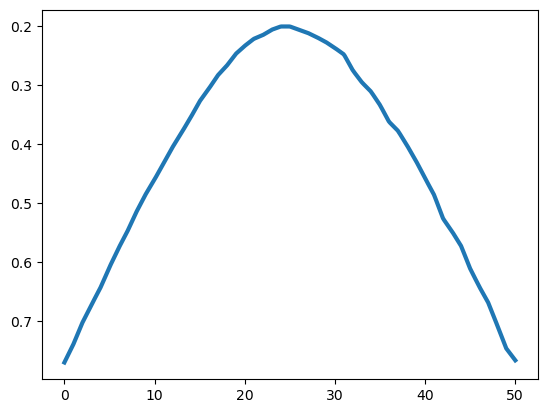

In [14]:
import numpy as np
import matplotlib.pyplot as plt
time = mat['t'].flatten()
delta_t = time[1]

c = 299792458
delta_r = c*delta_t
d = 1
interp_b_scan_cnt = 400
delta_d = d/interp_b_scan_cnt

r0 = 0.2
offset = min(max_indices)*delta_r - r0
print(offset)

# Define the original x-axis values
x_original = np.arange(len(max_indices))

# Define the new x-axis values for interpolation
x_interpolated = np.linspace(0, len(max_indices) - 1, interp_b_scan_cnt)

# Perform interpolation on max_values
max_values_interpolated = np.interp(x_interpolated, x_original, max_indices)

# Plot the interpolated max_values
plt.plot(x_interpolated, [x * delta_r - offset for x in max_values_interpolated], label='Ez', lw=3)
plt.gca().invert_yaxis()
plt.show()


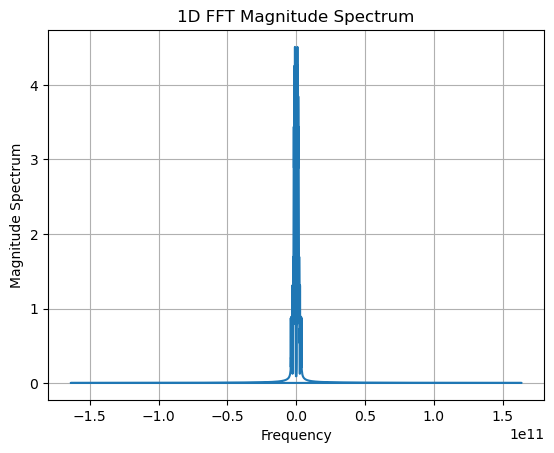

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the 1D array as 'data'

# Compute the FFT
fft_data = np.fft.fft(data[:,10])

# Compute the magnitude spectrum
magnitude_spectrum = np.abs(fft_data)

# Compute the corresponding frequencies
sampling_rate = 1/delta_t  # Assuming a sampling rate of 1 (can be adjusted)
n = len(data)  # Length of the data array
freq = np.fft.fftfreq(n, d=1/sampling_rate)

# Display the magnitude spectrum
plt.plot(freq, magnitude_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Magnitude Spectrum')
plt.title('1D FFT Magnitude Spectrum')
plt.grid(True)
plt.show()


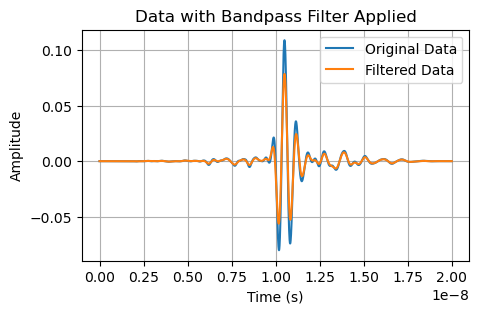

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, filtfilt

# Assuming you have the 1D array as 'data'

# Define the filter parameters
sampling_rate = 1/delta_t  # Sample rate (adjust as per your data)
low_freq = 10.0  # Lower cutoff frequency of the bandpass filter (in Hz)
high_freq = 100.0  # Upper cutoff frequency of the bandpass filter (in Hz)
filter_order = 100  # Order of the FIR filter

# Calculate the normalized frequencies
nyquist_freq = 0.5 * sampling_rate
low_freq_norm = low_freq / nyquist_freq
high_freq_norm = high_freq / nyquist_freq

# Design the FIR filter using the specified parameters
fir_coeff = firwin(filter_order, [low_freq_norm, high_freq_norm], pass_zero=False)

# Apply the filter to the data using filtfilt for zero-phase filtering
filtered_data = filtfilt(fir_coeff, [1], bscan_data_windowed[:,10])

# Plot the original and filtered data
time = np.arange(len(bscan_data_windowed[:,10])) / sampling_rate

plt.figure(figsize=(5, 3))
plt.plot(time, bscan_data_windowed[:,10], label='Original Data')
plt.plot(time, filtered_data, label='Filtered Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Data with Bandpass Filter Applied')
plt.legend()
plt.grid(True)
plt.show()


## Theory Study

In [ ]:
import matplotlib.pyplot as plt
import h5py
# Get Data from file
def get_out_data(filename):
    with h5py.File(filename, 'r') as f:
        return f['rxs']['rx1']['Ez'][()]
    
file_names = ['Study/src_rx_70cm.out','Study/src_rx_50cm.out','Study/src_rx_40cm.out','Study/src_rx_30cm.out','Study/src_rx_20cm.out','Study/src_rx_10cm.out']
Ez_list = []

for fn in file_names:
    Ez_list.append(get_out_data(fn))

N = len(Ez_list[0])  # Assuming the lengths of Ez, Ez1, and Ez2 are the same

# Create a single figure and axis
fig, ax = plt.subplots(nrows = 6, figsize=(8, 4))

for i in range(6):
    # Plot the three arrays as separate lines
    ax[i].plot(range(N), Ez_list[i], label='Ez', lw=3)

# Show the plot
plt.show()

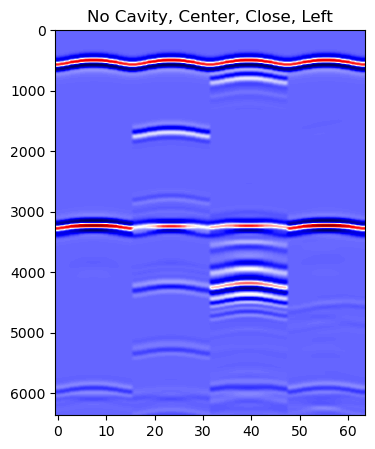

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
file_names = [
       'circle_rx_cavity_none.out',
       'circle_rx_cavity_center.out',
       'circle_rx_cavity_left.out',
       'circle_rx_cavity_bottom.out',
       ]
Ez_list = []

# Get Data from file
def get_out_data(filename):
    with h5py.File('Study/' + filename, 'r') as f:
        return f['rxs']['rx1']['Ez'][()]

# Load the data from each file
for fn in file_names:
    Ez_list.append(get_out_data(fn))

Ez_src = get_out_data('circle_rx_src_only.out')

Ez0 = Ez_src[:, np.newaxis]  # Add a new axis

Ez0 = np.repeat(Ez0, 16, axis=1)
# Compute the differences relative to the first file
Ez_diff_list = [np.subtract(Ez, Ez0) for Ez in Ez_list]

# Concatenate the arrays along the second axis
Ez = np.concatenate(Ez_diff_list, axis=1)

# DC Blocking
column_means = np.mean(Ez, axis=0)
Ez = Ez - column_means[np.newaxis, :]

# Set the desired width and height of the figure
fig_width = 1 * len(file_names)
fig_height = 5

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(Ez, cmap='seismic', aspect='auto')
plt.title('No Cavity, Center, Close, Left')
# Display the plot
plt.show()


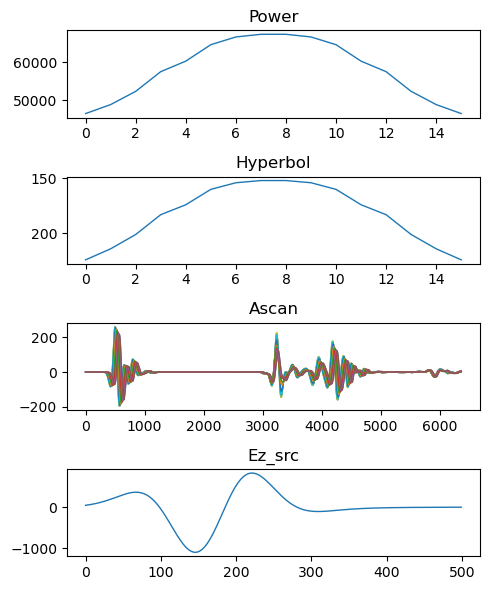

In [4]:
# Data
data = np.copy(Ez_diff_list[2])
wavelet = Ez_src[200:700]
#Zero Peak
zero_peak = np.argmin(Ez0[:,0])
# Find the global maximum for each column
first_reflection_power = np.square(np.max(data, axis=0))
first_reflection_distance = np.argmax(data, axis=0) - zero_peak 
sample_ascan = data[:,10]

# Create a single figure and axis
fig, ax = plt.subplots(nrows = 4, figsize=(5, 6))
ax[0].plot(range(len(first_reflection_power)), first_reflection_power, label='first_reflection_power', lw=1)
ax[0].set_title('Power')
ax[1].plot(range(len(first_reflection_distance)), first_reflection_distance, label='first_reflection_distance', lw=1)
ax[1].set_title('Hyperbol')
ax[1].invert_yaxis()
ax[2].plot(range(len(data)), data, label='sample_ascan', lw=1)
ax[2].set_title('Ascan')
ax[3].plot(range(len(wavelet)), wavelet, label='Ez_src', lw=1)
ax[3].set_title('Ez_src')
plt.tight_layout()
# Show the plot
plt.show()

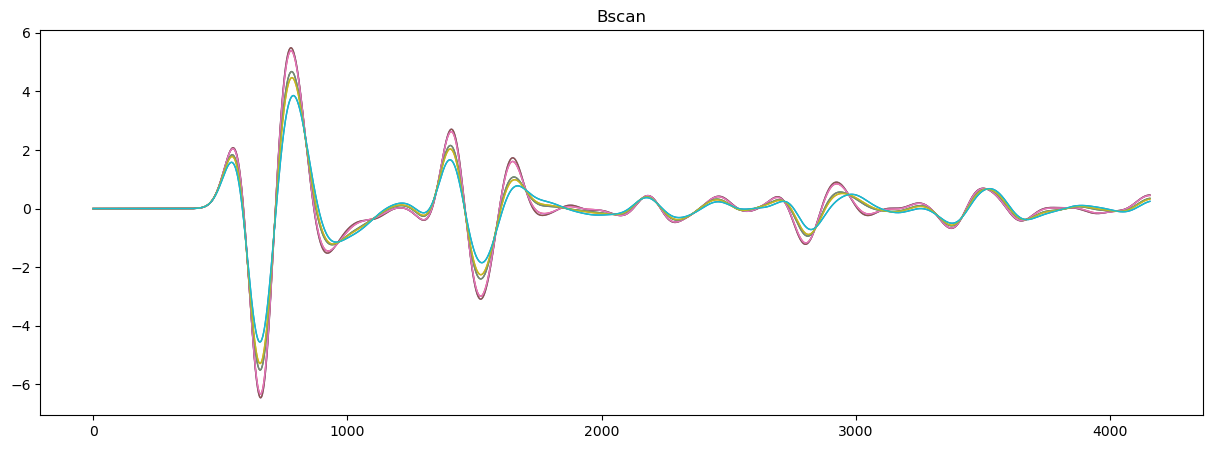

In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
with h5py.File('GSSI/rotating_atenna_3D_cavity_center.out', 'r') as f:
    bscan =  f['rxs']['rx1']['Ey'][()]

with h5py.File('GSSI/rotating_atenna_3D_src_only.out', 'r') as f:
    Ez0 =  f['rxs']['rx1']['Ey'][()]

bscan = np.concatenate((bscan, bscan[:,::-1]), axis = 1)

Ez0 = Ez0[:, np.newaxis]  # Add a new axis
Ez0 = np.repeat(Ez0, bscan.shape[1], axis=1)
# Compute the differences relative to the first file
bscan = np.subtract(bscan, Ez0)
# Create a single figure and axis
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(range(len(bscan)), bscan, lw=1)
ax.set_title('Bscan')
plt.show()

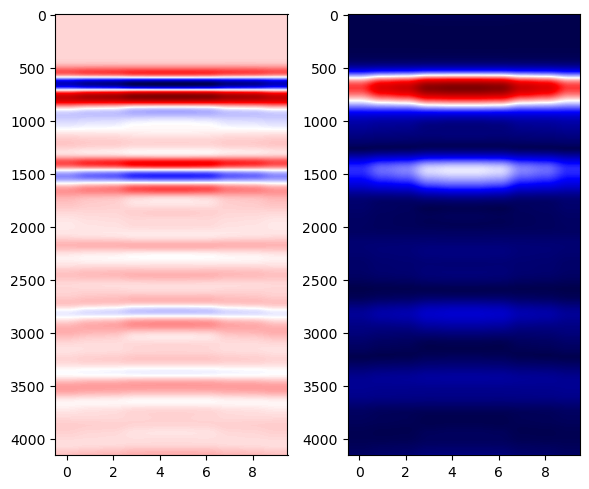

In [13]:
import numpy as np
from scipy.signal import hilbert
# Perform 2D Hilbert transform column-wise
hilbert_transform = np.apply_along_axis(hilbert, axis=0, arr=bscan)

# Extract envelope and phase information
envelope = np.abs(hilbert_transform)
phase = np.angle(hilbert_transform)

# Set the desired width and height of the figure
fig_width = 6
fig_height = 5

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(ncols=2, figsize=(fig_width, fig_height))

# Generate the image
ax[0].imshow(bscan, cmap='seismic', aspect='auto')
ax[1].imshow(envelope, cmap='seismic', aspect='auto')
plt.tight_layout()
# Display the plot
plt.show()


In [3]:
sampling_rate = 6361/3e-8
sampling_rate

212033333333.33334

In [525]:
# -*- coding: utf-8 -*-
"""
The Python implementation of the fast-oopsi algorithm

port from the matlab code by jovo:
https://github.com/jovo/oopsi

@author: liubenyuan <liubenyuan AT gmail DOT com>
@date: 2014-04-16
"""
import numpy as np
import numpy.linalg as lp
from scipy.signal import lfilter, detrend
from scipy.sparse import spdiags, eye
from scipy.sparse.linalg.dsolve import linsolve


# return mean absolute deviation MAD of F
def oopsi_mad(F):
    """
    python implementation of fast-oopsi, functional blocks are
        fast():
            oopsi_init_par()
            oopsi_est_map()
            while:
                oopsi_est_par()
                oopsi_est_map()
    util functions are,
        oopsi_mad() : mad estimator
        oopsi_m() : generate matric M, where (MC)=n
    this implementation (and jovo's MATLAB) utilize sparse matrix for
    speedup. using scipy.sparse.spdiags and scipy.sparse.eye, Hessian
    equation Hd=g is solved via linsolve.spsolve.
    """
    return np.median(np.abs(F - np.median(F)))


# return sparse bidiagonal matrix
def oopsi_m(gamma, T):
    return spdiags([-gamma * np.ones(T), np.ones(T)], [-1, 0], T, T)


# initialize parameters
def oopsi_init_par(F, dt):
    epsilon = 1e-16
    T = F.shape[0]  # signal length
    F = detrend(F)  # normalize F
    F = (F - F.min()) / (F.max() - F.min()) + epsilon
    a = 1.0  # without scale information
    b = np.median(F)  # baseline, alternate np.percentile(F,0.05)
    lam = 1.0
    gam = 1.0 - dt / 1.0
    sig = oopsi_mad(F) * 1.4826  # median as robust normal scale estimator
    P = {
        "T": T,
        "dt": dt,
        "gamma": gam,
        "alpha": a,
        "beta": b,
        "sigma": sig,
        "lambda": lam,
    }
    return F, P


# map estimator of F
def oopsi_est_map(F, P):
    # extract parameters from dict (turples)
    T, dt, gam, a, b, sig, lam = (
        P[k] for k in ("T", "dt", "gamma", "alpha", "beta", "sigma", "lambda")
    )
    # initialize n,C,llam
    n = 0.01 + np.zeros(T)
    C = lfilter([1.0], [1.0, -gam], n)
    llam = (lam * dt) * np.ones(T)
    # M, H, H1, H2 are 'sparse' matrix, therefore
    # we can directly multiply it with a vector (without np.dot)
    M = oopsi_m(gam, T)
    grad_lnprior = M.T * llam
    H1 = (a**2) / (sig**2) * eye(T)
    z = 1.0  # weight on barrier function
    while z > 1e-13:
        D = F - a * C - b  # residual
        lik = 1 / (2 * (sig**2)) * np.dot(D.T, D)
        post = lik + np.dot(llam.T, n) - z * np.sum(np.log(n))  # calculate L
        s = 1.0
        d = 1.0
        while (lp.norm(d) > 5e-2) and (s > 1e-3):  # conv for z
            glik = -a / (sig**2) * (F - a * C - b)
            g = glik + grad_lnprior - z * (M.T * (1 / n))  # gradient, g
            H2 = spdiags(1 / (n**2), 0, T, T)
            H = H1 + z * (M.T * H2 * M)  # Hessian, H
            d = linsolve.spsolve(H, g)  # direction to step
            # find s
            hit = n / (M * d)  # steps within constraint boundaries
            hit = hit[hit > 0]
            if any(hit < 1):
                s = 0.99 * hit.min()
            else:
                s = 1.0
            # loop over s
            post1 = post + 1.0
            while post1 > post + 1e-7:  # goal: newton step decrease objective
                C1 = C - s * d
                n = M * C1
                D = F - a * C1 - b
                lik1 = 1 / (2 * (sig**2)) * np.dot(D.T, D)
                post1 = lik1 + np.dot(llam.T, n) - z * np.sum(np.log(n))
                s = s / 5.0
                if s < 1e-20:
                    break
            C = C1  # update C
            post = post1  # update post
        z = z / 10.0  # reduce z (sequence of z reductions is arbitrary)
    # clearing n[0],n[1] and normalize n between [0,1]
    n[0:2] = 1e-8
    n = n / n.max()
    return n, C, post


# parameters update for fast-oopsi
def oopsi_est_par(n, C, F, P):
    T, dt, gam, a, b, sig, lam = (
        P[k] for k in ("T", "dt", "gamma", "alpha", "beta", "sigma", "lambda")
    )
    # update
    a = 1.0
    b = np.sum(F - C) / T  # mean bias
    D = F - a * C - b
    mse = np.dot(D.T, D)
    sig = np.sqrt(mse / T)  # RMS of residual error
    lam = T / (dt * np.sum(n))  # inverse of firing rate, n should be normalized
    # packup
    P = {
        "T": T,
        "dt": dt,
        "gamma": gam,
        "alpha": a,
        "beta": b,
        "sigma": sig,
        "lambda": lam,
    }
    return P


# implement fast-oopsi
def fast(F, dt=0.02, iter_max=1, update=True):
    """
    <input:>
    F        - a column vector, fluorescence of a neuron (ROI), Tx1
    dt       - frame sampling interval
    iter_max - maximum iteration
    update   - if we are iterating to estimate parameters
    """
    # initialize parameters
    F, P = oopsi_init_par(F, dt)
    # one-shot Newton-Raphson
    n, C, post = oopsi_est_map(F, P)
    post_max = post
    n_best = n
    C_best = C
    # multiple-shot, if iter_max=0, exit
    ml = np.ones(iter_max)
    ml[0] = post
    # imax = 0
    for i in range(1, iter_max):
        # update parameters based on previous iteration
        if update:
            P = oopsi_est_par(n, C, F, P)
        # update inferred spike train based on new parameters
        n, C, post = oopsi_est_map(F, P)
        if post > post_max:
            n_best = n
            C_best = C
            post_max = post
        # if lik doesnt change much (relatively),or return to a previous state
        ml[i] = post
        if np.abs((ml[i] - ml[i - 1]) / ml[i]) < 1e-3 or any(
            np.abs(ml[:i] - ml[i]) < 1e-5
        ):
            # imax = i
            break
    return n_best, C_best

C:\Users\thanh\AppData\Local\Temp\ipykernel_31028\2095574574.py:15: DeprecationWarning: The module `scipy.sparse.linalg.dsolve.linsolve` is deprecated. All public names must be imported directly from the `scipy.sparse.linalg` namespace.
  from scipy.sparse.linalg.dsolve import linsolve


Text(0.5, 1.0, 'd')

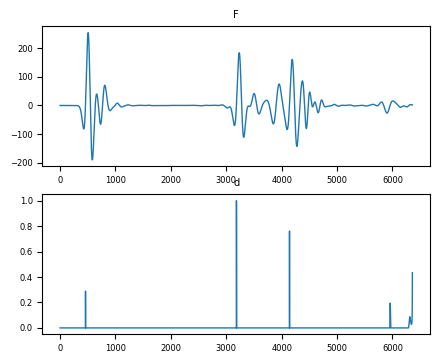

In [532]:
# -*- coding: utf-8 -*-
"""
demo files for py-oopsi
@author: liubenyuan <liubenyuan AT gmail DOT com>
"""
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

dt = 1/sampling_rate

F = np.copy(sample_ascan)

d, Cz = fast(F, dt=dt, iter_max=3)

# Create a single figure and axis
fig, ax = plt.subplots(nrows = 2, figsize=(5, 4))
ax[0].plot(range(len(F)), F, label='F', lw=1)
ax[0].set_title('F')
ax[1].plot(range(len(d)), d, label='d', lw=1)
ax[1].set_title('d')


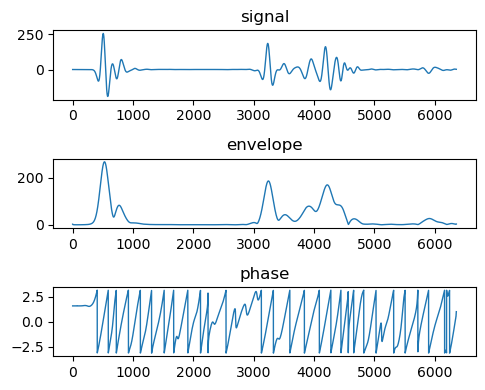

In [4]:
from scipy.fftpack import *

# Example input signal
signal = np.copy(sample_ascan)

def hilbert_from_scratch(u):
    # N : fft length
    # M : number of elements to zero out
    # U : DFT of u
    # v : IDFT of H(U)

    N = len(u)
    # take forward Fourier transform
    U = fft(u)
    M = N - N//2 - 1
    # zero out negative frequency components
    U[N//2+1:] = [0] * M
    # double fft energy except @ DC0
    U[1:N//2] = 2 * U[1:N//2]
    # take inverse Fourier transform
    v = ifft(U)
    return v

signal_HT = hilbert_from_scratch(signal)
signal_envelop = np.abs(signal_HT)
signal_phase = np.angle(signal_HT)

# Create a single figure and axis
fig, ax = plt.subplots(nrows = 3, figsize=(5, 4))
ax[0].plot(range(len(signal)), signal, label='signal', lw=1)
ax[0].set_title('signal')
ax[1].plot(range(len(signal_envelop)), signal_envelop, label='envelope', lw=1)
ax[1].set_title('envelope')
ax[2].plot(range(len(signal_phase)), signal_phase, label='phase', lw=1)
ax[2].set_title('phase')
plt.tight_layout()
# Show the plot
plt.show()

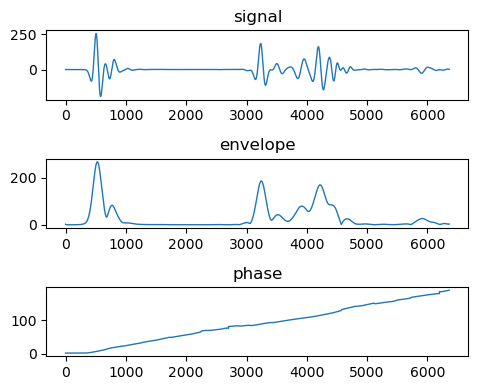

In [5]:
import numpy as np

# Example array of angles
# Example array of angles
# signal_phase = np.array([0.5, 1.2, 2.8, -2.9, -2.5, 1.1, 0.2, -0.8, -3.0, -2.6, 1.3])

# Find indexes where the angle changes from positive to negative
transition_indexes = []
for i in range(1, len(signal_phase)):
    if signal_phase[i] < 0 and signal_phase[i-1] >= 0:
        transition_indexes.append(i)

# Modify the original array
modified_signal_phase = signal_phase.copy()
increment = 2*np.pi
for i in range(len(transition_indexes)):
    modified_signal_phase[transition_indexes[i]:] += increment

# Create a single figure and axis
fig, ax = plt.subplots(nrows = 3, figsize=(5, 4))
ax[0].plot(range(len(signal)), signal, label='signal', lw=1)
ax[0].set_title('signal')
ax[1].plot(range(len(signal_envelop)), signal_envelop, label='envelope', lw=1)
ax[1].set_title('envelope')
ax[2].plot(range(len(modified_signal_phase)), modified_signal_phase, label='phase', lw=1)
ax[2].set_title('phase')
plt.tight_layout()
# Show the plot
plt.show()

Shape of wavelet transform:  (99, 6361)


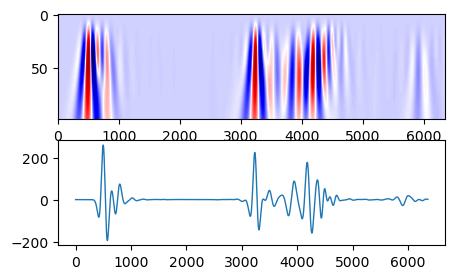

In [371]:
wavelet = 'mexh' # wavelet type: morlet
sr = 1e9 # sampling frequency: 8KHz
widths = np.arange(1, 100) # scales for morlet wavelet 
# print("These are the scales that we are using: ", widths)
dt = 1/sr # timestep difference

frequencies = pywt.scale2frequency(wavelet, widths) / dt # Get frequencies corresponding to scales
# print("These are the frequencies that re associated with the scales: ", frequencies)

# Compute continuous wavelet transform of the audio numpy array
wavelet_coeffs, freqs = pywt.cwt(sample_ascan, widths, wavelet = wavelet, sampling_period=dt)
print("Shape of wavelet transform: ", wavelet_coeffs.shape)

# Set the desired width and height of the figure
fig_width = 5
fig_height = 3

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(nrows = 2, figsize=(fig_width, fig_height))

# Generate the image
ax[0].imshow(wavelet_coeffs, cmap='seismic', aspect='auto')
ax[1].plot(range(len(sample_ascan)), sample_ascan, label='signal', lw=1)
# Display the plot
plt.show()


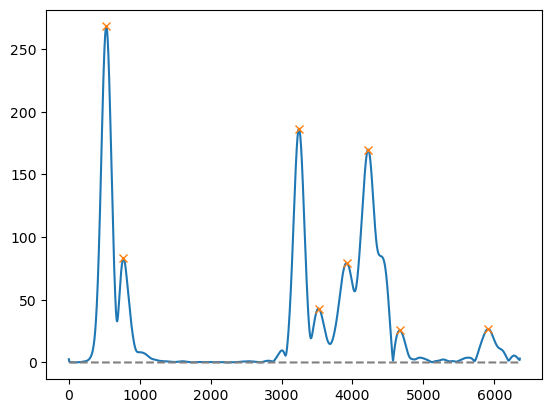

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

peaks, _ = find_peaks(signal_envelop, height=10, distance = 200)
peaks = peaks

plt.plot(signal_envelop)
plt.plot(peaks, signal_envelop[peaks], "x")
plt.plot(np.zeros_like(signal_envelop), "--", color="gray")
plt.show()

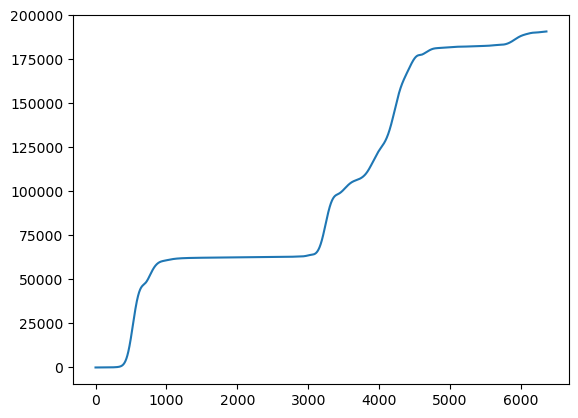

In [7]:
def integration(arr):
    result = []
    total = 0
    for num in arr:
        total += num
        result.append(total)
    return result

plt.plot(integration(signal_envelop))
plt.show()

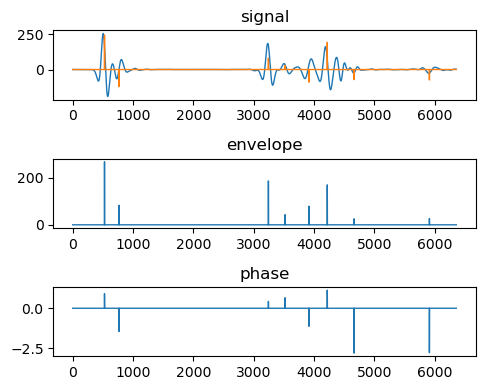

In [58]:
phase_rep = np.zeros_like(signal)
phase_rep[peaks] = signal_phase[peaks]

envelop_rep = np.zeros_like(signal)
envelop_rep[peaks] = signal_envelop[peaks]

signal_rep = phase_rep*envelop_rep
# Create a single figure and axis
fig, ax = plt.subplots(nrows = 3, figsize=(5, 4))
ax[0].plot(range(len(signal)), signal, label='signal', lw=1)
ax[0].plot(range(len(signal_rep)), signal_rep, label='signal_rep', lw=1)
ax[0].set_title('signal')
ax[1].plot(range(len(envelop_rep)), envelop_rep, label='envelope', lw=1)
ax[1].set_title('envelope')
ax[2].plot(range(len(phase_rep)), phase_rep, label='phase', lw=1)
ax[2].set_title('phase')
plt.tight_layout()
# Show the plot
plt.show()

## Methods

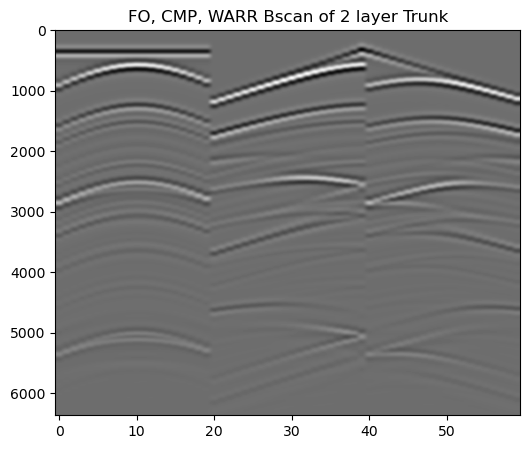

In [150]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

Ez_list = []

# Get Data from file
def get_out_data(filename):
    with h5py.File(filename, 'r') as f:
        return f['rxs']['rx1']['Ez'][()]

# FO Source Only
Ez0 = get_out_data('Study/methods_FO_src_only.out')
Ez0 = Ez0[:, np.newaxis]  # Add a new axis
Ez0_FO = np.repeat(Ez0, 20, axis=1)
# CMP Source only
Ez0_CMP = get_out_data('Study/methods_CMP_src_only.out')
# WARR Source only
Ez0_WARR = get_out_data('Study/methods_WARR_src_only.out')

# FO
Ez_FO = np.subtract(get_out_data('Study/methods_FO.out'), 0.9 * Ez0_FO)
# CMP
Ez_CMP = np.subtract(get_out_data('Study/methods_CMP.out'), 0.9 * Ez0_CMP)
#WARR
Ez_WARR = np.subtract(get_out_data('Study/methods_WARR.out'), 0.9 * Ez0_WARR)

Ez_list.append(Ez_FO)
Ez_list.append(Ez_CMP)
Ez_list.append(Ez_WARR)

# Concatenate the arrays along the second axis
plot = np.concatenate(Ez_list, axis=1)

# Set the desired width and height of the figure
fig_width = 6
fig_height = 5

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(plot, cmap='gray', aspect='auto')
plt.title('FO, CMP, WARR Bscan of 2 layer Trunk')
# Display the plot
plt.show()


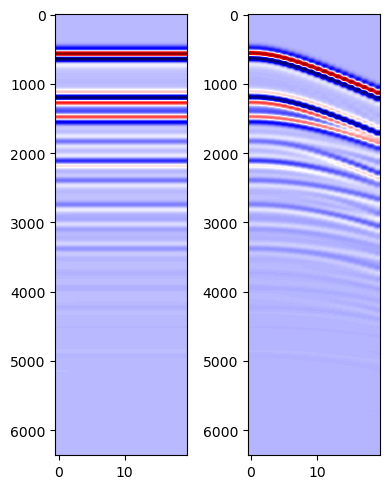

In [42]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

Ez_list = []

# Get Data from file
def get_out_data(filename):
    with h5py.File(filename, 'r') as f:
        return f['rxs']['rx1']['Ez'][()]

# FO Source Only
Ez0 = get_out_data('Study/methods_FO_src_only.out')
Ez0 = Ez0[:, np.newaxis]  # Add a new axis
Ez0_FO = np.repeat(Ez0, 20, axis=1)
# CMP Source only
Ez0_CMP = get_out_data('Study/bark_cavity_bark_CMP_background.out')
# WARR Source only
Ez0_WARR = get_out_data('Study/methods_WARR_src_only.out')

# FO
Ez_FO = np.subtract(get_out_data('Study/bark_cavity_bark_FO.out'), Ez0_FO)
# CMP
Ez_CMP = np.subtract(get_out_data('Study/bark_cavity_bark_CMP.out'), Ez0_CMP)
#WARR
Ez_WARR = np.subtract(get_out_data('Study/methods_WARR_3layers.out'), Ez0_WARR)

Ez_list.append(Ez_FO)
Ez_list.append(Ez_CMP)
# Ez_list.append(Ez_WARR)

# Concatenate the arrays along the second axis
plot = np.concatenate(Ez_list, axis=1)

# Set the desired width and height of the figure
fig_width = 4
fig_height = 5

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(ncols = 2, figsize=(fig_width, fig_height))

# Generate the image
ax[0].imshow(Ez_FO, cmap='seismic', aspect='auto')
ax[1].imshow(Ez_CMP, cmap='seismic', aspect='auto')

plt.tight_layout()
# Display the plot
plt.show()


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Get Data from file
def get_out_data(filename):
    with h5py.File(filename, 'r') as f:
        return f['rxs']['rx1']['Ez'][()]

#WARR
Ez_WARR = np.subtract(get_out_data('Study/methods_CMP_1layer.out'), Ez0_WARR)

# Set the desired width and height of the figure
fig_width = 2
fig_height = 5

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(Ez_WARR, cmap='seismic', aspect='auto')

# Display the plot
plt.show()


## Misc

In [ ]:
import matplotlib.pyplot as plt
import random
# Specify the mean, standard deviation, resolution, minimum value, and maximum value
mean = 0
stddev = 0.1
resolution = 0.002
min_value = -0.3
max_value = 0.3

def generate_random_with_high_probability(mean, stddev, resolution, min_value, max_value):
        while True:
            random_value = random.normalvariate(mean, stddev)
            rounded_value = round(random_value / resolution) * resolution
            if min_value <= rounded_value <= max_value:
                return rounded_value

# Generate a random value with a high probability of returning the mean value within the specified range
values = []

# Generate random values with a high probability of returning the mean value
for _ in range(10000):
    random_value = generate_random_with_high_probability(mean, stddev, resolution, min_value, max_value)
    values.append(random_value)

# Plot the distribution curve
plt.hist(values, bins='auto', density=True)
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Distribution of Random Values')
plt.grid(True)
plt.show()


In [109]:
#Draw a Circle using Points

import math

center_x = 20
center_y = 30
radius = 10
num_points = 50

points = []
for i in range(num_points):
    angle = 2 * math.pi * i / num_points
    x = center_x + radius * math.cos(angle)
    y = center_y + radius * math.sin(angle)
    points.append((x, y))

## Computed Tomography Architecture

### gprMax setup

In [2]:
import math

def find_full_combinations(n):
    combinations = []
    max_value = math.isqrt(n) + 1  # Square root of n rounded up

    for a in range(max_value):
        for b in range(max_value):
            if a**2 + b**2 == n:
                # combinations.append((a, b))
                # combinations.append((-a, b))
                # combinations.append((a, -b))
                combinations.append((-a, -b))
    combinations.sort(key=lambda x: x[0])  # Sort combinations by first element
    return combinations


In [45]:
max_len = 0
i_max = 0
for i in range (150**2,200**2):
    result = find_full_combinations(i)  
    if len(result) > max_len:
        max_len = len(result)
        i_max = i
print(max_len, i_max)


32 27625


In [24]:
import matplotlib.pyplot as plt

def plot_combinations(combinations):
    x = [point[0] for point in combinations]
    y = [point[1] for point in combinations]
    
    plt.scatter(x, y)
    plt.grid(True)
    plt.axis('equal')
    plt.show()
arr = find_full_combinations(170**2)[5:]
n = 0.5
for x, y in arr:
    print(x*n,y*n)
# plot_combinations(find_full_combinations(27625))

-51.0 -68.0
-40.0 -75.0
-36.0 -77.0
-13.0 -84.0
0.0 -85.0


In [18]:
def offset_and_scale_points(points, offset, scale):
    rounded_points = [(round(x * scale, len(str(scale).split('.')[1])), round(y * scale, len(str(scale).split('.')[1]))) for (x, y) in points]
    transformed_points = [(round(x + offset[0], len(str(scale).split('.')[1])), round(y + offset[1], len(str(scale).split('.')[1]))) for (x, y) in rounded_points]
    return transformed_points

In [25]:
offset_and_scale_points(find_full_combinations(170**2), (0.215,0.29), 0.001*1.5)

[(-0.04, 0.29),
 (-0.037, 0.251),
 (-0.016, 0.182),
 (-0.01, 0.17),
 (0.011, 0.137),
 (0.062, 0.086),
 (0.095, 0.065),
 (0.107, 0.059),
 (0.176, 0.038),
 (0.215, 0.035)]

(0.113, 0.194)


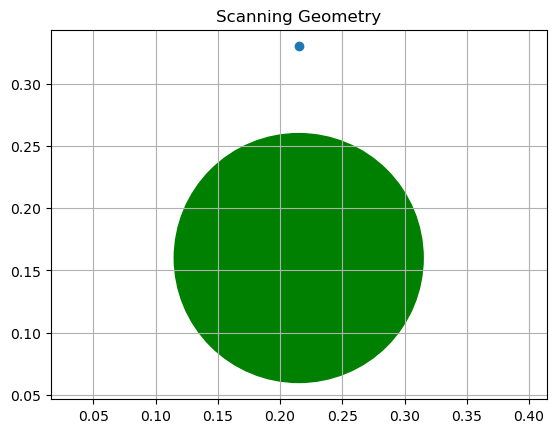

In [10]:
pos = offset_and_scale_points(find_full_combinations(170**2), (0.28-0.065,0.33), 0.001)
circle1 = plt.Circle(pos[9], 0.1, color='green')
print(pos[5])
plt.gca().add_patch(circle1)
plt.scatter(0.215, 0.33)
plt.title('Scanning Geometry')
plt.grid(True)
plt.gca().set_aspect("equal")
plt.axis('equal')
plt.show()

In [1]:
current_model_run = 3
# for current_model_run in range(1,8):
center_array = [
(0.12, 0.21),
(0.16, 0.17),
(0.224, 0.138),
(0.28, 0.13),
(0.336, 0.138),
(0.4, 0.17),
(0.44, 0.21)]
x,z = center_array[current_model_run - 1]
print('#cylinder: {} 0 {} {} 0.148 {} 0.100 trunk'.format(x,z,x,z))

#cylinder: 0.224 0 0.138 0.224 0.148 0.138 0.100 trunk


In [2]:
import math

def find_combinations(n):
    combinations = []
    max_value = math.isqrt(n) + 1  # Square root of n rounded up

    for a in range(max_value):
        for b in range(max_value):
            if a**2 + b**2 == n:
                combinations.append((a, b))
                combinations.append((-a, b))
    combinations.sort(key=lambda x: x[0])  # Sort combinations by first element
    return combinations

def scale_points(points, scale):
    rounded_points = [(round(x * scale, len(str(scale).split('.')[1])), round(y * scale, len(str(scale).split('.')[1]))) for (x, y) in points]
    return rounded_points

def source_positions(start, step, count):
    combinations = []
    x, y = start
    s_x,s_y = step
    for i in range(count):
        combinations.append((x + i * s_x, y + i *s_y))
    transformed_points = [(round(a, len(str(x).split('.')[1])), round(b, len(str(y).split('.')[1]))) for (a, b) in combinations]
    return transformed_points

In [3]:
src_array = source_positions((0.16, 0.06), (0.04, 0), 21)
# src_array

In [4]:
rx_array = scale_points(find_combinations(2125), 0.002)
# rx_array

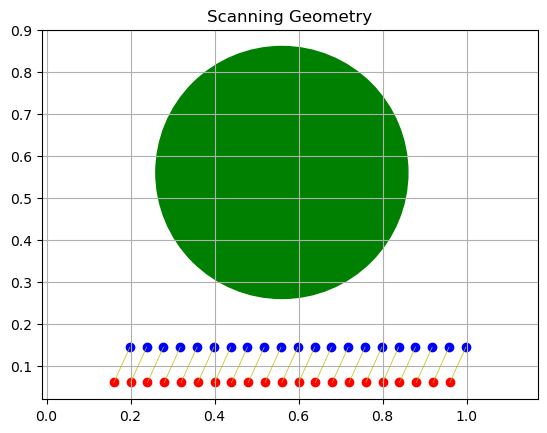

In [128]:
import matplotlib.pyplot as plt

# Create empty lists to store the coordinates
x_src_points = []
y_src_points = []
x_rx_points = []
y_rx_points = []

# # Loop through the range of current_model_run
# for current_model_run in range(1,17):
for current_model_run in range(11,337,16):
    x_src, y_src = src_array[int((current_model_run - 1) / 16)]
    x_rx_tmp, y_rx_tmp = rx_array[(current_model_run - 1) % 16]
    x_rx = round(x_src + x_rx_tmp, 3)
    y_rx = round(y_src + y_rx_tmp, 3)
    
    # Append the coordinates to the respective lists
    x_src_points.append(x_src)
    y_src_points.append(y_src)
    x_rx_points.append(x_rx)
    y_rx_points.append(y_rx)

# Scatter plot the points
plt.plot([x_src_points, x_rx_points], [y_src_points, y_rx_points], 'y-', label='Line',lw = 0.5)
plt.scatter(x_src_points, y_src_points, label='(x_src, y_src)', color='red')
plt.scatter(x_rx_points, y_rx_points, label='(x_rx, y_rx)', color='blue')


circle1 = plt.Circle((0.56, 0.56), 0.3, color='green')
plt.gca().add_patch(circle1)

# Add labels and title
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')
plt.title('Scanning Geometry')
plt.grid(True)
plt.gca().set_aspect("equal")
plt.axis('equal')
# Add legend

# Display the plot
plt.show()


In [82]:
#title: Healthy Tree
#domain: 1.120 0.920 0.002
#dx_dy_dz: 0.002 0.002 0.002
#time_window: 3e-08

#material: 5.000 0 1 0 trunk
#material: 1.000 0 1 0 cavity
#pml_cells: 25 25 0 25 25 0

#cylinder: 0.560 0.560 0 0.560 0.560 0.002 0.300 trunk
#cylinder: 0.460 0.460 0 0.460 0.460 0.002 0.090 cavity

#waveform: ricker 1 1e9 my_ricker
#python:
src_array = [
 (0.16, 0.06),
 (0.2, 0.06),
 (0.24, 0.06),
 (0.28, 0.06),
 (0.32, 0.06),
 (0.36, 0.06),
 (0.4, 0.06),
 (0.44, 0.06),
 (0.48, 0.06),
 (0.52, 0.06),
 (0.56, 0.06),
 (0.6, 0.06),
 (0.64, 0.06),
 (0.68, 0.06),
 (0.72, 0.06),
 (0.76, 0.06),
 (0.8, 0.06),
 (0.84, 0.06),
 (0.88, 0.06),
 (0.92, 0.06),
 (0.96, 0.06)]
 
rx_array = [
 (-0.092, 0.006),
 (-0.09, 0.02),
 (-0.084, 0.038),
 (-0.07, 0.06),
 (-0.06, 0.07),
 (-0.038, 0.084),
 (-0.02, 0.09),
 (-0.006, 0.092),
 (0.006, 0.092),
 (0.02, 0.09),
 (0.038, 0.084),
 (0.06, 0.07),
 (0.07, 0.06),
 (0.084, 0.038),
 (0.09, 0.02),
 (0.092, 0.006)]

x_src, y_src = src_array[int((current_model_run - 1)/16)]
x_rx_tmp, y_rx_tmp = rx_array[(current_model_run - 1)%16]
x_rx = round(x_src + x_rx_tmp, 3)
y_rx = round(y_src + y_rx_tmp, 3)

print('#hertzian_dipole: z {} {} 0.000 my_ricker'.format(x_src,y_src))
print('#rx: {} {} 0.000'.format(x_rx,y_rx))
#end_python:

#geometry_objects_write: 0 0 0 1.120 0.920 0.002 healthy_full
#geometry_objects_write: 0.260 0.260 0 0.860 0.860 0.002 healthy


#hertzian_dipole: z 0.96 0.06 0.000 my_ricker
#rx: 0.89 0.12 0.000


In [ ]:
#title: Healthy Tree
#domain: 0.335 0.148 0.350
#dx_dy_dz: 0.001 0.001 0.001
#time_window: 8e-9

#material: 10 0 1 0 trunk
#material: 1 0 1 0 cavity

#python:
center_array = [
 (0.113, 0.154),
 (0.135, 0.14),
 (0.143, 0.136),
 (0.189, 0.122),
 (0.215, 0.12)]
x,z = center_array[current_model_run - 1]
print('#cylinder: {} 0 {} {} 0.148 {} 0.100 trunk'.format(x,z,x,z))

cavity_array = [
 (0.164, 0.222),
 (0.175, 0.215),
 (0.179, 0.213),
 (0.202, 0.206),
 (0.215, 0.205)]
x1,z1 = cavity_array[current_model_run - 1]
print('#cylinder: {} 0 {} {} 0.148 {} 0.010 pec'.format(x1,z1,x1,z1))

from user_libs.antennas.GSSI import antenna_like_GSSI_1500
antenna_like_GSSI_1500(0.215, 0.074, 0.28, 0.001)
#end_python:

#geometry_objects_write: 0 0 0 0.335 0.148 0.350 healthy_full
#geometry_objects_write: 0 0 0 0.335 0.148 0.350 healthy

### Data Processing

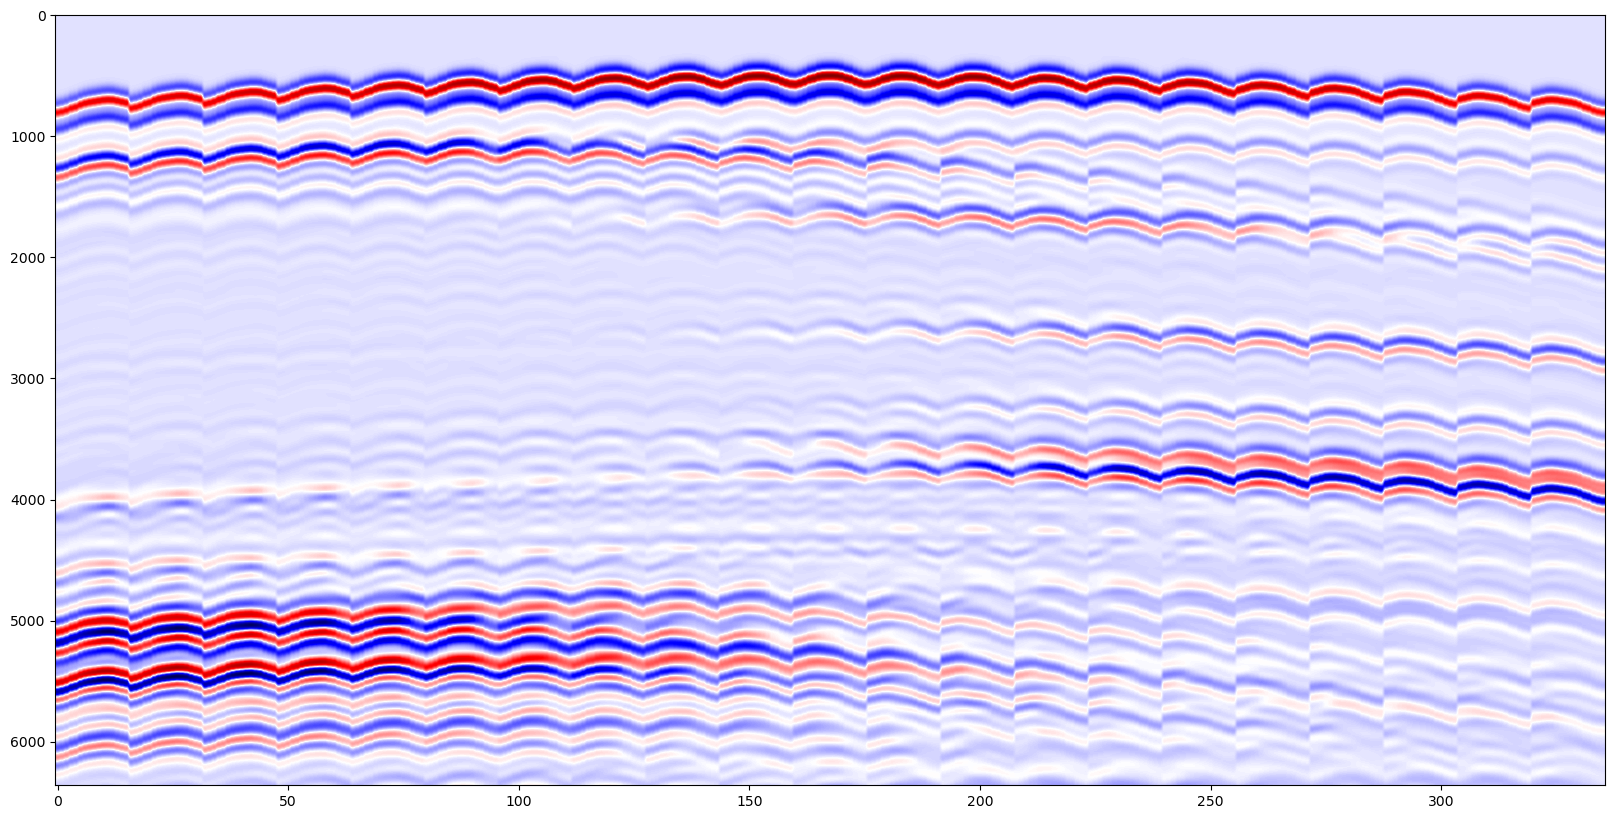

In [44]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
file_names = [
    #    'methods_CT_cylinder.out',
    #    'methods_CT_cavity.out',
    #    'methods_CT_cavity_2.out',
        'CT_scan/methods_CT_layered_cavity.out',
    #    'methods_CT_decay.out'
       ]
Ez_list = []

# Get Data from file
def get_out_data(filename):
    with h5py.File(filename, 'r') as f:
        return f['rxs']['rx1']['Ez'][()]

# Load the data from each file
for fn in file_names:
    Ez_list.append(get_out_data(fn))

Ez0 = get_out_data('CT_scan/methods_rotating_src_only.out')

Ez0 = Ez0[:, np.newaxis]  # Add a new axis

Ez0 = np.repeat(Ez0, 336, axis=1)
# Compute the differences relative to the first file
Ez_diff_list = [np.subtract(Ez, Ez0) for Ez in Ez_list]

# Concatenate the arrays along the second axis
Ez = np.concatenate(Ez_diff_list, axis=1)

# # DC Blocking
# column_means = np.mean(Ez, axis=0)
# Ez = Ez - column_means[np.newaxis, :]

# Set the desired width and height of the figure
fig_width = 20 
fig_height = 10

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(Ez, cmap='seismic', aspect='auto')
# Display the plot
plt.show()


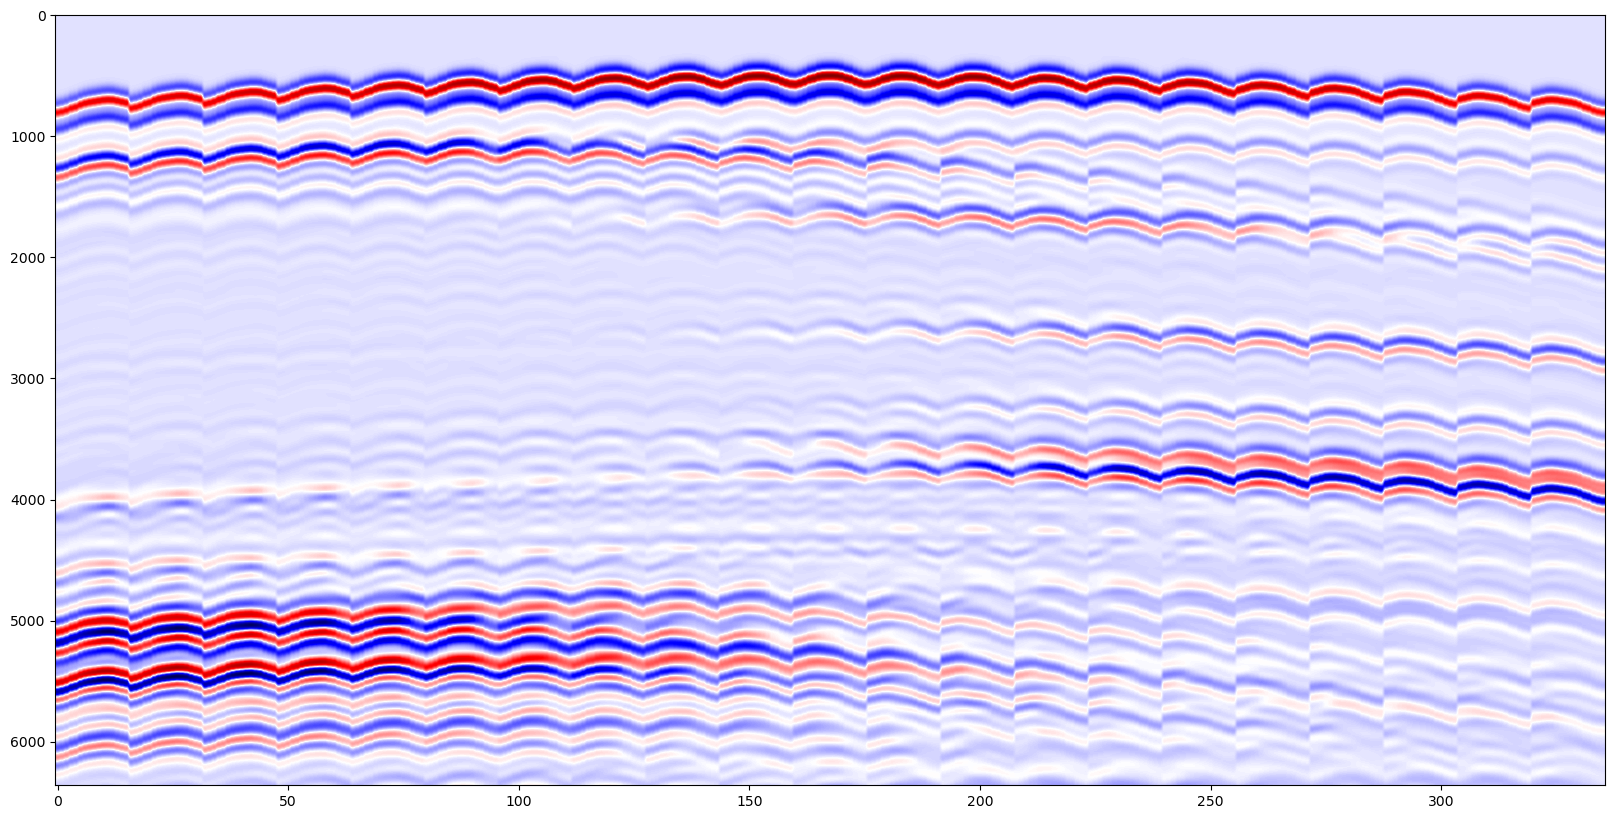

In [46]:
bscan = np.copy(Ez)
from scipy.signal import hilbert
# Perform 2D Hilbert transform column-wise
hilbert_transform = np.apply_along_axis(hilbert, axis=0, arr=bscan)

# Extract envelope and phase information
envelope = np.abs(hilbert_transform)
phase = np.angle(hilbert_transform)
    
# Set the desired width and height of the figure
fig_width = 20
fig_height = 10

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(bscan, cmap='seismic', aspect='auto')
# Display the plot
plt.show()

In [128]:
envelope.shape[0]/2

3895.0

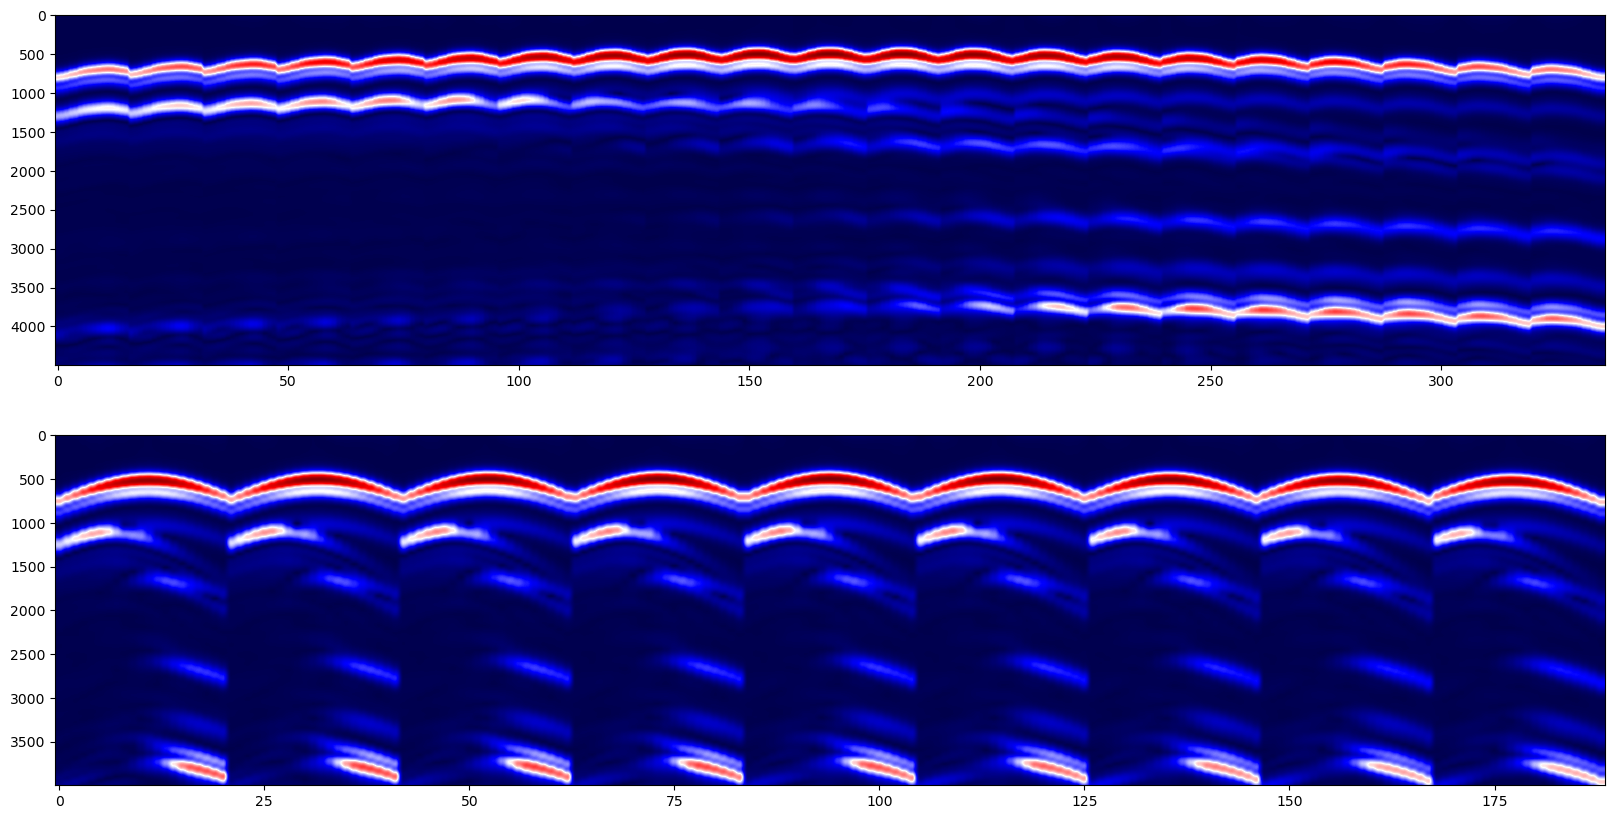

In [3]:
angle_array_envelop = []

for i in range(4,13):
    # Extract the new array of shape (6361, 16)
    angle_array_envelop.append(envelope[:4000, i::16])

circle_array_envelop = []

for i in range(21):
    # Extract the new array of shape (6361, 16)
    circle_array_envelop.append(envelope[:4500, 16*i:16*i+16])

CT_scan_envelop =  np.concatenate(angle_array_envelop, axis=1)
circular_scan_envelop = np.concatenate(circle_array_envelop, axis=1)
# Set the desired width and height of the figure
fig_width = 20
fig_height = 10

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(nrows=2, figsize=(fig_width, fig_height))

# Generate the image
ax[0].imshow(circular_scan_envelop, cmap='seismic', aspect='auto')
ax[1].imshow(CT_scan_envelop, cmap='seismic', aspect='auto')
# Display the plot
plt.show()

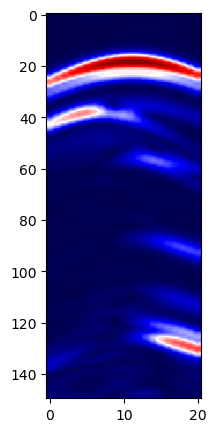

In [4]:
from skimage.transform import resize

CT_scan_3D = np.stack(angle_array_envelop, axis = 2)
CT_scan_3D = resize(CT_scan_3D, (150,21,9))

circular_scan_3D = np.stack(circle_array_envelop, axis = 2)
circular_scan_3D = resize(circular_scan_3D, (150,16,21))

# Set the desired width and height of the figure
fig_width = 2
fig_height = 5

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(circular_scan_3D[:,0,:], cmap='seismic', aspect='auto')
# Display the plot
plt.show()

In [ ]:
import numpy as np

points = find_combinations(2125)

# Convert the list of points to a NumPy array
points_arr = np.array(points)

# Calculate the angles
angles = np.arctan2(points_arr[:, 1], points_arr[:, 0])

# Convert angles to degrees
angles_deg = np.degrees(angles)

# Print the resulting array of angles
plt.scatter(range(len(angles_deg)), angles_deg[::-1])


In [ ]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.transform import resize


rotated_array = []
for i in range(len(angle_array_envelop)):
    rotated = ndimage.rotate(resize(angle_array_envelop[i][:,:], (225, 30)), angles_deg[i], reshape=True)
    rotated_array.append(rotated)

def place_array_in_middle(large_array, small_array):
    # Calculate the indices to place the small array in the middle of the large array
    row_start = (large_array.shape[0] - small_array.shape[0]) // 2
    col_start = (large_array.shape[1] - small_array.shape[1]) // 2
    row_end = row_start + small_array.shape[0]
    col_end = col_start + small_array.shape[1]

    # Place the small array in the middle of the large array
    large_array[row_start:row_end, col_start:col_end] += small_array

    return large_array


# Example usage
large_array = np.zeros((230, 230))

for small_array in rotated_array:
    large_array = place_array_in_middle(large_array, small_array)

# Print the large array
plt.imshow(large_array, 'gray')


## Shape Generation

In [1]:
import math
import random
def generate_random_convex_polygon(n):
    x_pool = [random.random() for _ in range(n)]
    y_pool = [random.random() for _ in range(n)]

    x_pool.sort()
    y_pool.sort()

    min_x = x_pool[0]
    max_x = x_pool[n - 1]
    min_y = y_pool[0]
    max_y = y_pool[n - 1]

    x_vec = []
    y_vec = []
    last_top = min_x
    last_bot = min_x

    for i in range(1, n - 1):
        x = x_pool[i]

        if random.choice([True, False]):
            x_vec.append(x - last_top)
            last_top = x
        else:
            x_vec.append(last_bot - x)
            last_bot = x

    x_vec.append(max_x - last_top)
    x_vec.append(last_bot - max_x)

    last_left = min_y
    last_right = min_y

    for i in range(1, n - 1):
        y = y_pool[i]

        if random.choice([True, False]):
            y_vec.append(y - last_left)
            last_left = y
        else:
            y_vec.append(last_right - y)
            last_right = y

    y_vec.append(max_y - last_left)
    y_vec.append(last_right - max_y)

    random.shuffle(y_vec)

    vec = [Point2D(x, y) for x, y in zip(x_vec, y_vec)]

    vec.sort(key=lambda v: math.atan2(v.y, v.x))

    x = 0
    y = 0
    min_polygon_x = 0
    min_polygon_y = 0
    points = []

    for i in range(n):
        points.append(Point2D(x, y))

        x += vec[i].x
        y += vec[i].y

        min_polygon_x = min(min_polygon_x, x)
        min_polygon_y = min(min_polygon_y, y)

    x_shift = min_x - min_polygon_x
    y_shift = min_y - min_polygon_y

    for i in range(n):
        p = points[i]
        points[i] = Point2D(p.x + x_shift, p.y + y_shift)

    return points

class Point2D:
    def __init__(self, x, y):
        self.x = x
        self.y = y


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def find_boundary_points(arr):
    # Identify the boundary positions
    boundary_mask = np.zeros_like(arr, dtype=bool)
    boundary_mask[1:-1, 1:-1] = ((
        (arr[1:-1, :-2] == 0)
        | (arr[1:-1, 2:] == 0)
        | (arr[:-2, 1:-1] == 0)
        | (arr[2:, 1:-1] == 0))
        & (arr[1:-1, 1:-1] == 1)
    )

    # Extract the boundary positions as (x, y) coordinates
    boundary_points = np.column_stack(np.where(boundary_mask))

    return boundary_points

def make_boundary_zero(arr):
    boundary_points = find_boundary_points(arr)
    arr[boundary_points[:, 0], boundary_points[:, 1]] = 0
    return arr

def make_non_boundary_zero(arr):
    boundary_points = find_boundary_points(arr)
    arr = np.zeros_like(arr)
    arr[boundary_points[:, 0], boundary_points[:, 1]] = 1
    return arr

def find_closest_point(points_array, x, y):
    distances = np.sqrt(np.sum((points_array - np.array([x,y]))**2, axis=1))
    index = np.argmin(distances)
    return points_array[index]

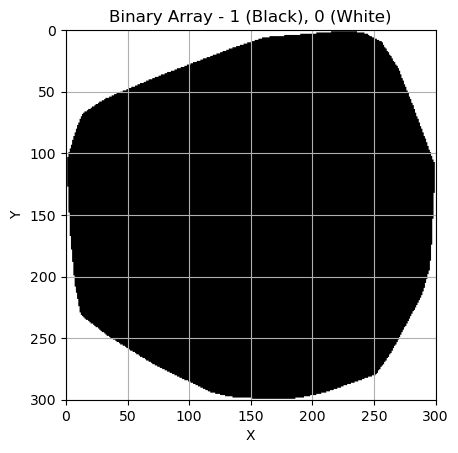

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath

# Set the resolution of the binary array
resolution = 300  # Adjust as needed for desired resolution

# Generate the convex polygon points
n = 40  # Number of points
points = generate_random_convex_polygon(n)

# Extract x and y coordinates
x_coords = [point.x for point in points]
y_coords = [point.y for point in points]

# Create a matplotlib Path object from the polygon points
polygon_path = mpath.Path(np.column_stack((x_coords, y_coords)))

# Define the bounding box to encompass the polygon
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)


# Generate the binary array representing the polygon
x_vals = np.linspace(x_min, x_max, resolution)
y_vals = np.linspace(y_min, y_max, resolution)

outline_array = np.zeros((resolution, resolution), dtype=int)

for i, y in enumerate(y_vals):
    for j, x in enumerate(x_vals):
        if polygon_path.contains_point((x, y)):
            outline_array[i, j] += 1

# Plot the binary array
plt.imshow(outline_array, cmap='binary', origin='lower', vmin=0, vmax=1, extent=[0, outline_array.shape[1], outline_array.shape[0], 0])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Array - 1 (Black), 0 (White)')
plt.grid(True)
plt.show()


## Bscan approximation and Reconstruction

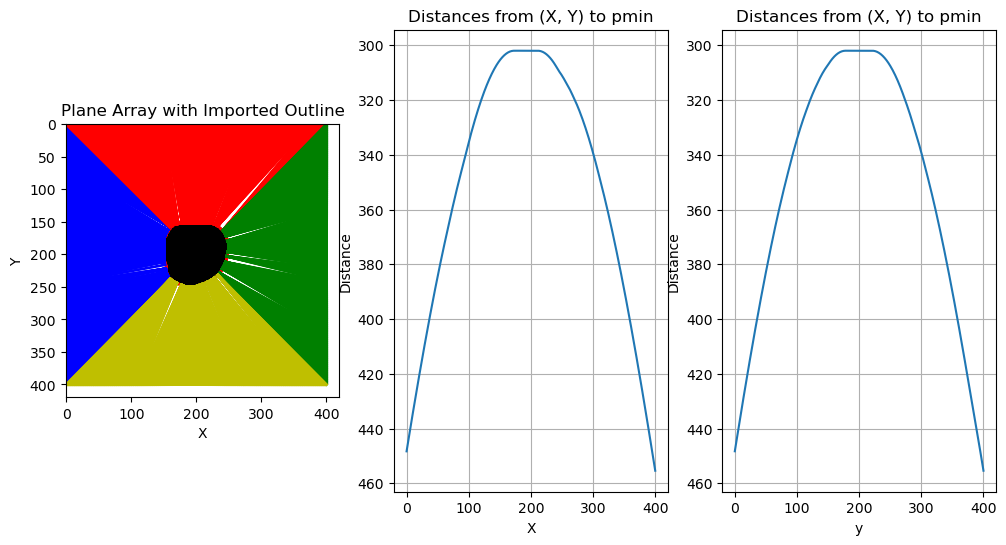

In [94]:
# Define the size of the plane_array
plane_width = 400
plane_height = 400
y_src = 0
x_src = 0
y_src2 = 400
x_src2 = 400

# Define the starting position of the outline_array in the plane_array
start_x = int((plane_width-resolution)/2)
start_y = int((plane_height-resolution)/2)


# Create the plane_array
plane_array = np.zeros((plane_height, plane_width), dtype=int)

# Calculate the ending positions of the outline_array
end_x = start_x + outline_array.shape[1]
end_y = start_y + outline_array.shape[0]

# Import the outline_array into the plane_array
plane_array[start_y:end_y, start_x:end_x] = outline_array

# Find boundary points
boundary_points = find_boundary_points(plane_array)

# Create a figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# Plot the plane_array
ax1.imshow(plane_array, cmap='binary', origin='lower', vmin=0, vmax=1)
ax1.invert_yaxis()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Plane Array with Imported Outline')
# Scatter plot the boundary_points
ax1.scatter(boundary_points[:, 1], boundary_points[:, 0], c='red', marker='o', s=1, label='Boundary Points')

distances = []
distances_1 = []
distances_2 = []
distances_3 = []

for x in range(plane_height + 1):
    pmin = find_closest_point(boundary_points, x, y_src)
    ax1.plot([y_src, pmin[1]], [x, pmin[0]], 'b-', linewidth=2)
    
    # Calculate the distance between (x, y_src) and pmin
    distance = np.sqrt((x - pmin[0]) ** 2 + (y_src - pmin[1]) ** 2)
    distances.append(2*distance)

for y in range(plane_width + 1):
    qmin = find_closest_point(boundary_points, x_src, y)
    ax1.plot( [y, qmin[1]], [x_src, qmin[0]], 'r-', linewidth=2)
    
    # Calculate the distance between (x, y_src) and pmin
    distance_1 = np.sqrt((y - qmin[1]) ** 2 + (x_src - qmin[0]) ** 2)
    distances_1.append(2*distance_1)

for x in range(plane_height + 1):
    pmin = find_closest_point(boundary_points, x, y_src2)
    ax1.plot([y_src2, pmin[1]], [x, pmin[0]], 'g-', linewidth=2)
    
    # Calculate the distance between (x, y_src) and pmin
    distance_2 = np.sqrt((x - pmin[0]) ** 2 + (y_src2 - pmin[1]) ** 2)
    distances_2.append(2*distance_2)

for y in range(plane_width + 1):
    qmin = find_closest_point(boundary_points, x_src2, y)
    ax1.plot( [y, qmin[1]], [x_src2, qmin[0]], 'y-', linewidth=2)
    
    # Calculate the distance between (x, y_src) and pmin
    distance_3 = np.sqrt((y - qmin[1]) ** 2 + (x_src2 - qmin[0]) ** 2)
    distances_3.append(2*distance_3)


# Plot the distances on ax2
ax2.plot(range(plane_height + 1), distances)
ax2.set_xlabel('X')
ax2.set_ylabel('Distance')
ax2.invert_yaxis()
ax2.set_title('Distances from (X, Y) to pmin')
ax2.grid(True)

# Plot the distances on ax2
ax3.plot(range(plane_width + 1), distances_1)
ax3.set_xlabel('y')
ax3.set_ylabel('Distance')
ax3.invert_yaxis()
ax3.set_title('Distances from (X, Y) to pmin')
ax3.grid(True)

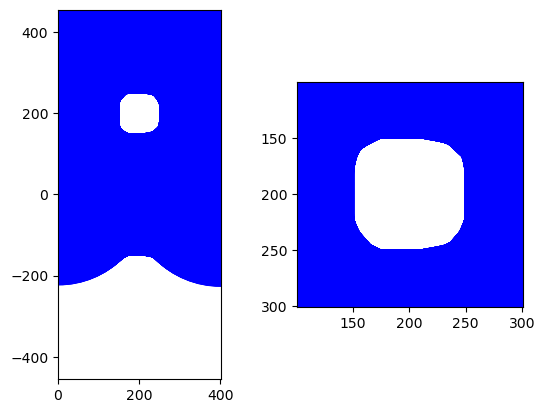

In [95]:
import matplotlib.pyplot as plt

def draw_circles(distances):
    fig, ax = plt.subplots(ncols=2)

    for i in range(len(distances)):
        # Get the coordinates and radius for the circle
        x = i + 1
        y = 0
        radius = distances[i]/2

        # Create a circle object and add it to the plot
        circle0 = plt.Circle((x, y), radius, edgecolor='none', facecolor='blue')
        circle1 = plt.Circle((x, y), radius, edgecolor='none', facecolor='blue')
        ax[0].add_patch(circle0)
        ax[1].add_patch(circle1)
    for i in range(len(distances_1)):
        # Get the coordinates and radius for the circle
        x = 0
        y = i+1
        radius = distances_1[i]/2

        # Create a circle object and add it to the plot
        circle0 = plt.Circle((x, y), radius, edgecolor='none', facecolor='blue')
        circle1 = plt.Circle((x, y), radius, edgecolor='none', facecolor='blue')
        ax[0].add_patch(circle0)
        ax[1].add_patch(circle1)
    for i in range(len(distances)):
        # Get the coordinates and radius for the circle
        x = i + 1
        y = 400
        radius = distances[i]/2

        # Create a circle object and add it to the plot
        circle0 = plt.Circle((x, y), radius, edgecolor='none', facecolor='blue')
        circle1 = plt.Circle((x, y), radius, edgecolor='none', facecolor='blue')
        ax[0].add_patch(circle0)
        ax[1].add_patch(circle1)

    for i in range(len(distances_1)):
        # Get the coordinates and radius for the circle
        x = 400
        y = i+1
        radius = distances_1[i]/2

        # Create a circle object and add it to the plot
        circle0 = plt.Circle((x, y), radius, edgecolor='none', facecolor='blue')
        circle1 = plt.Circle((x, y), radius, edgecolor='none', facecolor='blue')
        ax[0].add_patch(circle0)
        ax[1].add_patch(circle1)

    # Set the aspect ratio to 'equal' for circular circles
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    # ax[1].invert_yaxis()
    # ax[1].invert_xaxis()

    # Set the plot limits
    ax[1].set_xlim(len(distances)*0.25, len(distances)*0.75)
    ax[1].set_ylim(len(distances_1)*0.25, len(distances_1)*0.75)

    # Set the plot limits
    ax[0].set_xlim(0, len(distances))
    ax[0].set_ylim(-max(distances), max(distances))

    # Invert the y-axis
    ax[1].invert_yaxis()
    # Show the plot
    plt.show()

# Example usage
draw_circles(distances)


In [96]:
# Real Data
normalized_distance = [(x * delta_r - offset)/delta_d for x in max_values_interpolated]
draw_circles(normalized_distance)

NameError: name 'max_values_interpolated' is not defined

## h5 geometry files 

In [2]:
import h5py
import numpy as np
import os
from PIL import Image
res = 300
# Load the PNG image
image_path = "TreeGen/image/defect/defect0.png"
img = Image.open(image_path).convert('RGB')

# Resize the image to 200x200
img_resized = img.resize((res, res))

# Convert the resized image to a 2D array of integers
color_map = {
    (255, 255, 255): -1,  # White
    (255, 255, 0): 0,     # Yellow
    (255, 51, 0): 1       # Red
}

arr_2d = np.zeros((res, res), dtype=int)
for y in range(res):
    for x in range(res):
        pixel_color = img_resized.getpixel((x, y))
        arr_2d[y, x] = color_map.get(pixel_color, 0)

arr_3d = np.expand_dims(arr_2d, axis=2)

# Define the base filename
base_filename = "geo_png.h5"

# Check if the file already exists
suffix = 1
filename = base_filename
while os.path.exists(filename):
    suffix += 1
    filename = f"{base_filename.split('.h5')[0]}{suffix}.h5"

# Create a dataset within the 'data' group and store the array
with h5py.File(filename, 'w') as file:
    dset = file.create_dataset("data", data=arr_3d)

    # Add a root attribute with the name 'dx_dy_dz'
    file.attrs['dx_dy_dz'] = (0.002, 0.002, 0.002)


In [11]:
import h5py
import numpy as np
import os

# Define the base filename
base_filename = "geometry_generated.h5"

# Check if the file already exists
suffix = 1
filename = base_filename
while os.path.exists(filename):
    suffix += 1
    filename = f"{base_filename.split('.h5')[0]}{suffix}.h5"
cavity_array = np.where(outline_array == 1, 0, -1) #Replace with correct material index
# Create a new HDF5 file
arr_3d = np.expand_dims(cavity_array, axis=2)
# Create a dataset within the 'data' group and store the array
with h5py.File(filename, 'w') as file:
    dset = file.create_dataset("data", data=arr_3d)

    # Add a root attribute with the name 'dx_dy_dz'
    file.attrs['dx_dy_dz'] = (0.002, 0.002, 0.002)



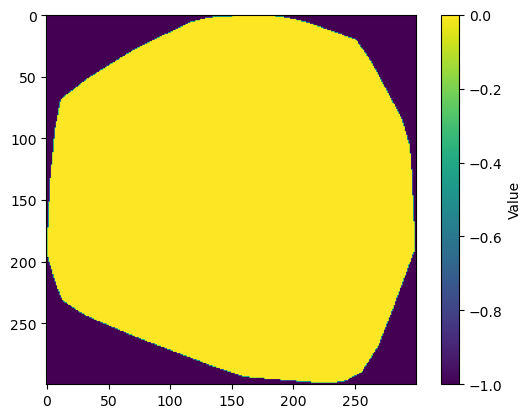

In [12]:
with h5py.File(filename, 'r') as f:
    dt = f['data'][()]

# Generate the image
plt.imshow(dt, cmap='viridis')

# Add a colorbar legend
cbar = plt.colorbar()
cbar.set_label('Value')

# Display the image
plt.show()
f.close()

## Signal Processing

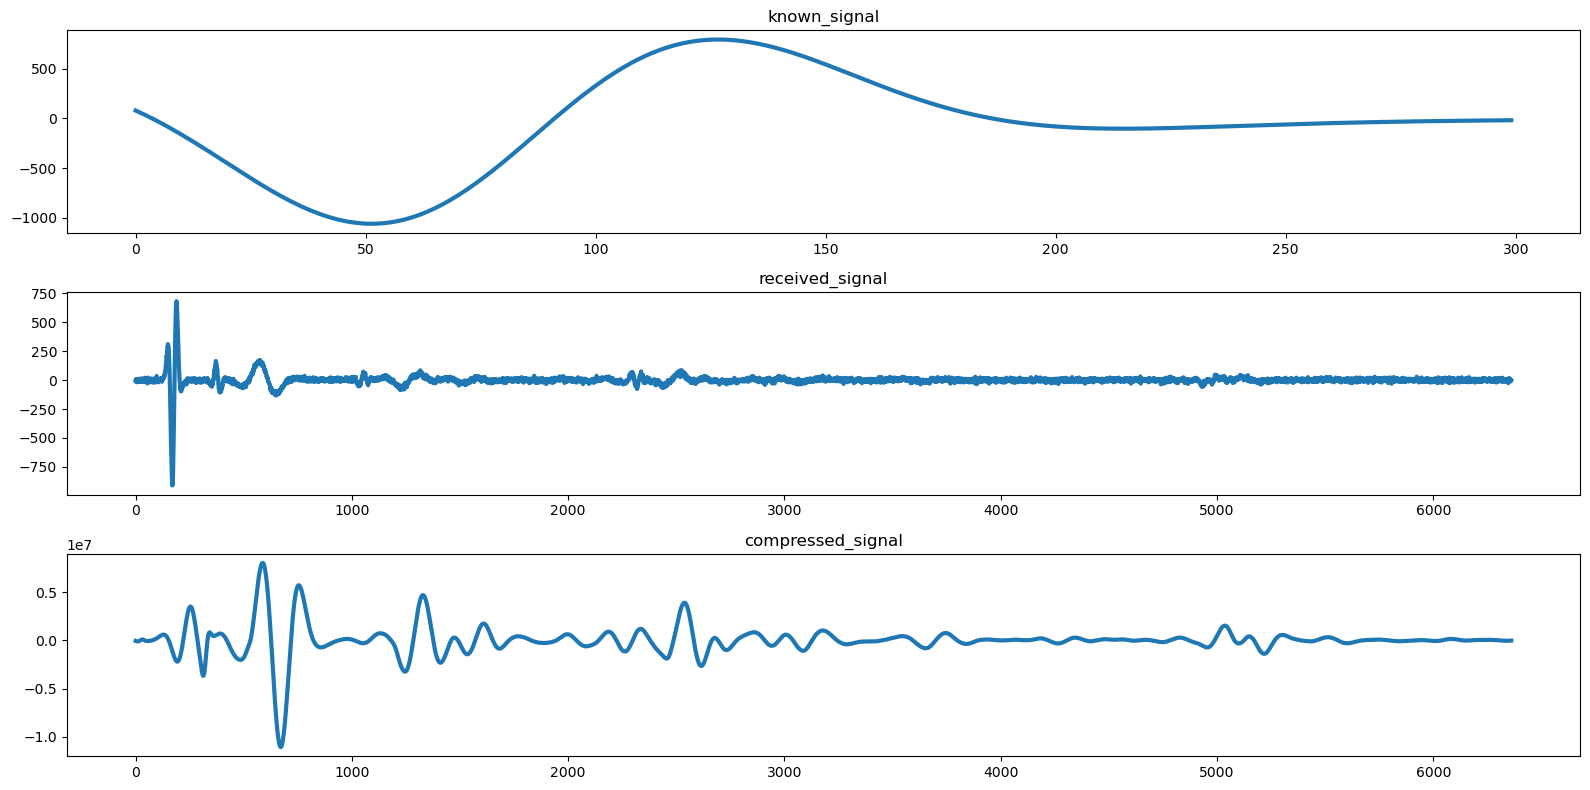

In [ ]:
#MATCH FILTERING
import numpy as np
import matplotlib.pyplot as plt

def get_out_data(filename):
    with h5py.File(filename, 'r') as f:
        return f['rxs']['rx1']['Ez'][()]

Ez0 = get_out_data('Study/noise_src_only.out')

Ez0_bscan = Ez0[:, np.newaxis]  # Add a new axis
Ez0_bscan = np.repeat(Ez0_bscan, 20, axis=1)

Ez = np.subtract(np.add(get_out_data('Study/noise_normal_src.out'), get_out_data('Study/noise.out')), Ez0_bscan)

# Define the known signal and received signal
known_signal = np.array(Ez0[300:600])  # Convert known signal to a 1D array
received_signal = np.array(Ez[:,10]).flatten()  # Convert received signal to a 1D array

# Add random noise to the signal
noise_amplitude = 10  # Adjust the amplitude of the noise
noise = np.random.normal(0, noise_amplitude, received_signal.shape)
received_signal = received_signal + noise

# Perform Match FIltering
compressed_signal = np.convolve(received_signal, known_signal[::-1], mode='same')

# Create a single figure and axis
fig, ax = plt.subplots(nrows = 3, figsize=(16, 8))
ax[0].plot(range(len(known_signal)), known_signal, label='known_signal', lw=3)
ax[0].set_title('known_signal')
ax[1].plot(range(len(received_signal)), received_signal, label='received_signal', lw=3)
ax[1].set_title('received_signal')
ax[2].plot(range(len(compressed_signal)), compressed_signal, label='compressed_signal', lw=3)
ax[2].set_title('compressed_signal')
plt.tight_layout()
# Show the plot
plt.show()

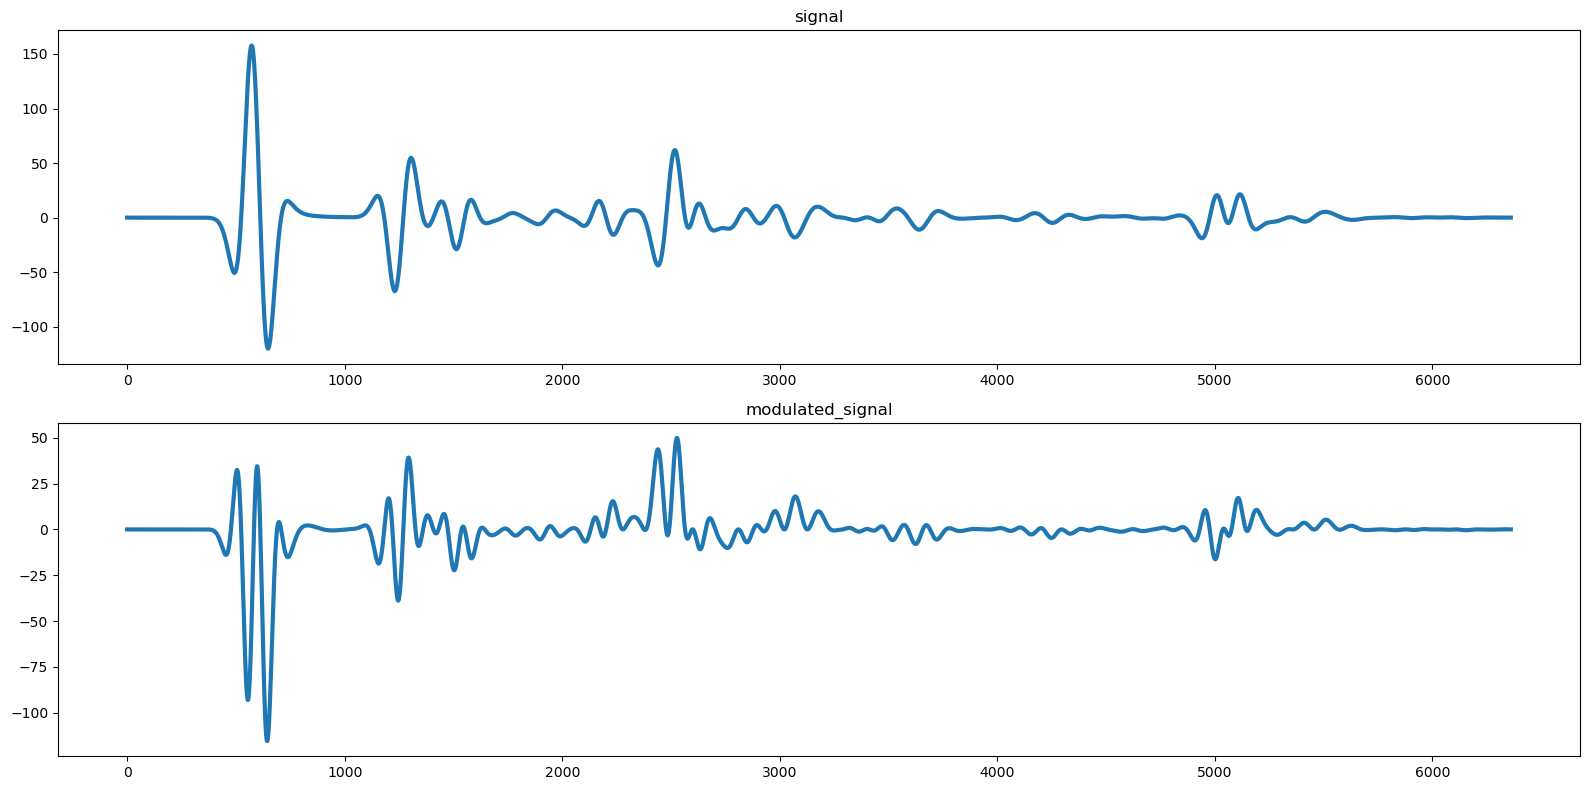

In [ ]:
#DEMODULATION
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

def get_out_data(filename):
    with h5py.File(filename, 'r') as f:
        return f['rxs']['rx1']['Ez'][()]

Ez0 = get_out_data('Study/noise_src_only.out')

Ez0_bscan = Ez0[:, np.newaxis]  # Add a new axis
Ez0_bscan = np.repeat(Ez0_bscan, 20, axis=1)

Ez = np.subtract(get_out_data('Study/noise_normal_src.out'), Ez0_bscan)

# Define the known signal and received signal
signal = np.array(Ez[:,10]).flatten()

time_division = 3e-8/6361
# Carrier frequency
carrier_frequency = 1e9

# Create the carrier waveform
t = np.arange(len(signal)) * time_division
carrier = np.cos(2 * np.pi * carrier_frequency * t)

# Modulate the signal with the carrier
modulated_signal = signal * carrier

# Create a single figure and axis
fig, ax = plt.subplots(nrows = 2, figsize=(16, 8))
ax[0].plot(range(len(signal)), signal, label='known_signal', lw=3)
ax[0].set_title('signal')

ax[1].plot(range(len(modulated_signal)), modulated_signal, label='modulated_signal', lw=3)
ax[1].set_title('modulated_signal')

plt.tight_layout()
# Show the plot
plt.show()

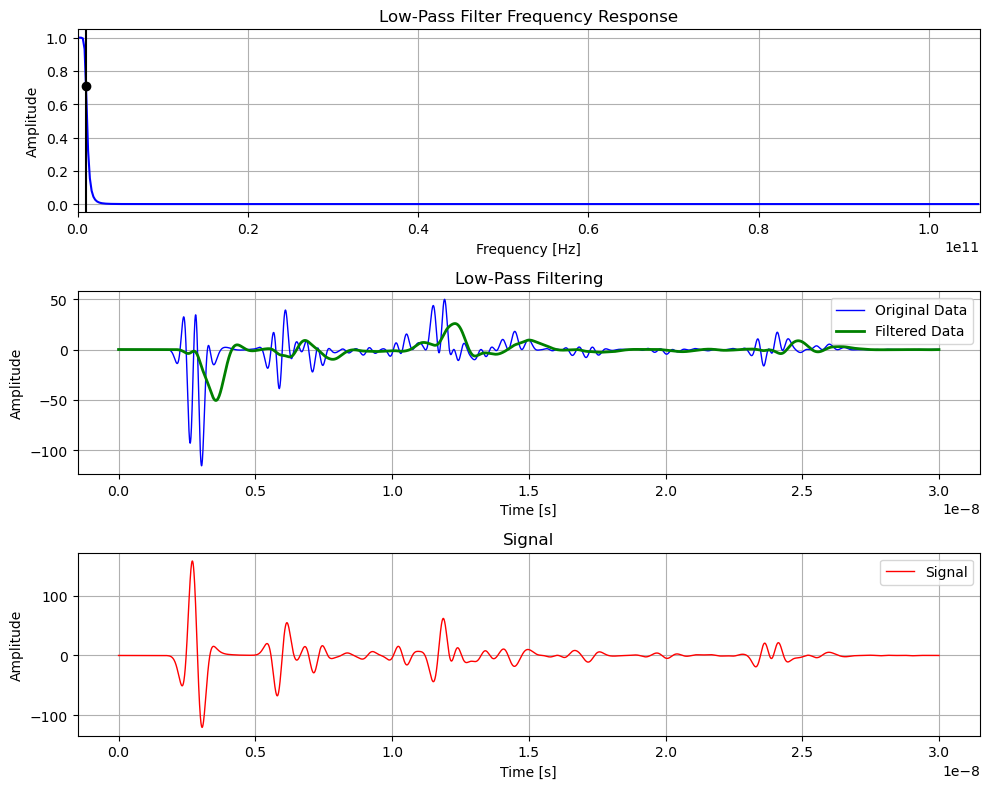

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements
order = 5
T = 3e-8  # Total time duration in seconds
n = 6361  # Number of samples
fs = n / T  # Calculating the correct sampling rate
cutoff = 1e9  # Desired cutoff frequency of the filter, Hz

# Generate time array
t = np.linspace(0, T, n, endpoint=False)

# Generate data array
data = np.copy(modulated_signal)  # Example data, a sine wave with a frequency of 1e9 Hz

# Filter the data
filtered_data = butter_lowpass_filter(data, cutoff, fs, order)

# Plot the original and filtered data
plt.figure(figsize=(10, 8))

# Frequency response of the filter
w, h = freqz(*butter_lowpass(cutoff, fs, order=order), fs=fs)
plt.subplot(3, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title('Low-Pass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid()

# Plot the original and filtered data
plt.subplot(3, 1, 2)
plt.plot(t, data, 'b-', linewidth = 1, label='Original Data')
plt.plot(t, filtered_data, 'g-', linewidth=2, label='Filtered Data')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Low-Pass Filtering')
plt.grid()
plt.legend()

# Plot the original and filtered data
plt.subplot(3, 1, 3)
plt.plot(t, signal, 'r-',linewidth = 1, label='Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Signal')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


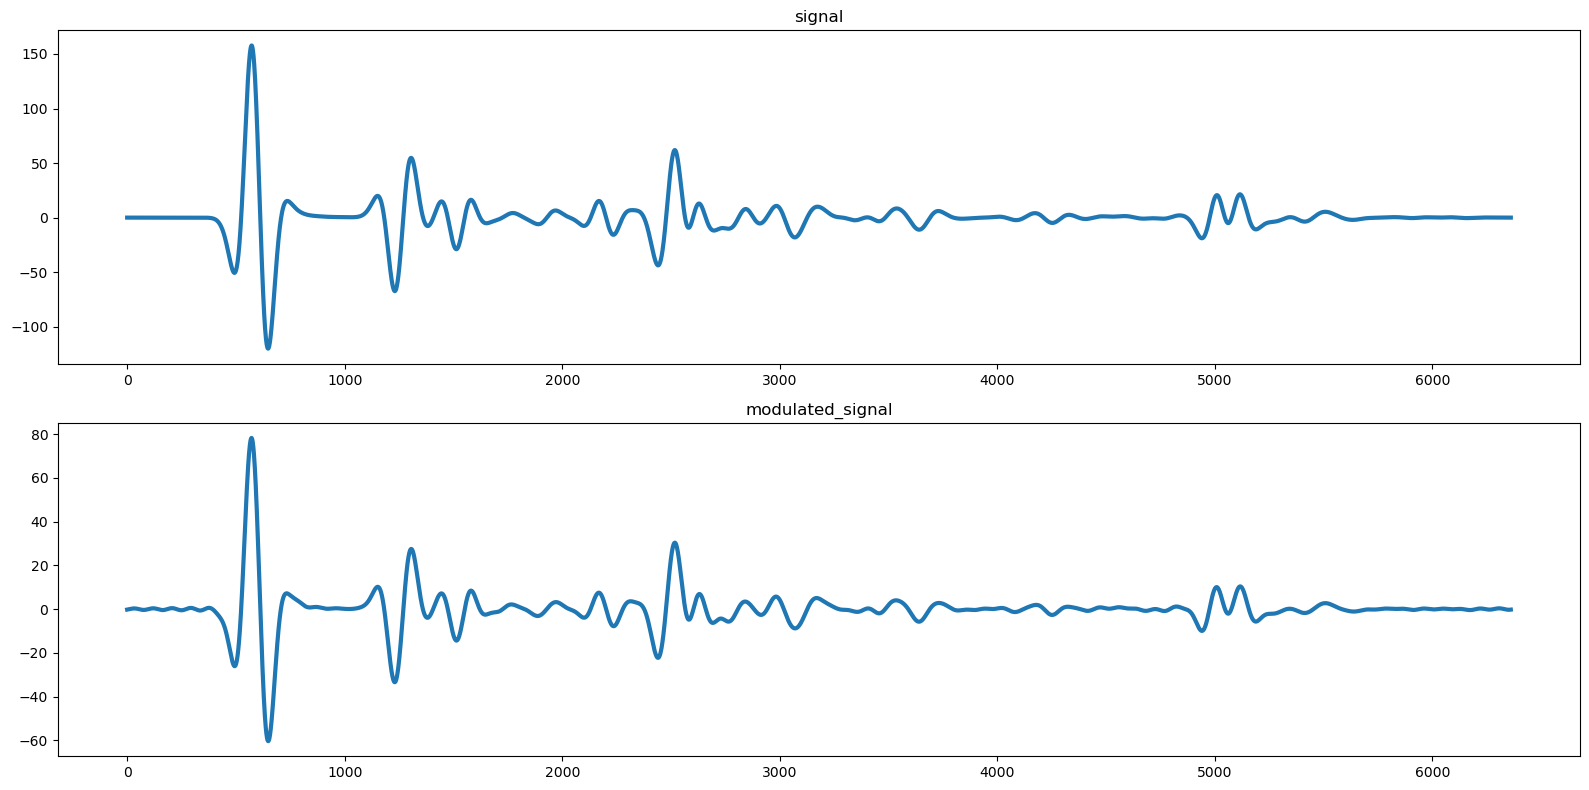

Dominant Frequency: 1200000000.0 Hz


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(len(signal))

time_division = 3e-8/len(signal)

signal = np.array(Ez[:,10]).flatten()

fft_result = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(signal), time_division)

dominant_freq_index = np.argmax(np.abs(fft_result))
dominant_freq = freqs[dominant_freq_index]

min_freq = 0  # Specify the minimum frequency
max_freq = 2*dominant_freq  # Specify the maximum frequency

filtered_indices = np.where((freqs >= min_freq) & (freqs <= max_freq))

reconstructed_fft = np.zeros_like(fft_result)
reconstructed_fft[filtered_indices] = fft_result[filtered_indices]

reconstructed_signal = np.fft.ifft(reconstructed_fft)

# Create a single figure and axis
fig, ax = plt.subplots(nrows = 2, figsize=(16, 8))
ax[0].plot(range(len(signal)), signal, label='known_signal', lw=3)
ax[0].set_title('signal')

ax[1].plot(range(len(reconstructed_signal)), reconstructed_signal, label='modulated_signal', lw=3)
ax[1].set_title('modulated_signal')

plt.tight_layout()
# Show the plot
plt.show()

print('Dominant Frequency:', dominant_freq, 'Hz')


## Edge Detection

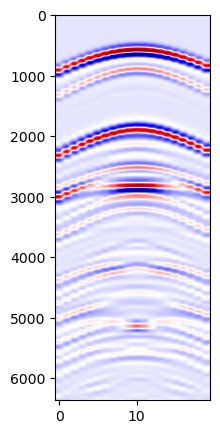

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_name = 'Study/eps_12_r_10_bark_shifted.out'
Ez_list = []

# Get Data from file
def get_out_data(filename):
    with h5py.File(filename, 'r') as f:
        return f['rxs']['rx1']['Ez'][()]

Ez0 = get_out_data('Study/src_only.out')[:,0][:,np.newaxis]
Ez0 = np.repeat(Ez0, 20, axis=1)

# Ez0 = get_out_data('Study/methods_CMP_src_only.out')

Ez = np.subtract(get_out_data(file_name), Ez0)

# Calculate the mean of each column
column_means = np.mean(Ez, axis=0)

# Remove the DC component from each column
Ez = Ez - column_means[np.newaxis, :]

Ez = Ez - np.min(Ez)
Ez = Ez/(np.max(Ez))

# Set the desired width and height of the figure
fig_width = 2
fig_height = 5

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Generate the image
plt.imshow(Ez, cmap='seismic', aspect='auto')

# Display the plot
plt.show()


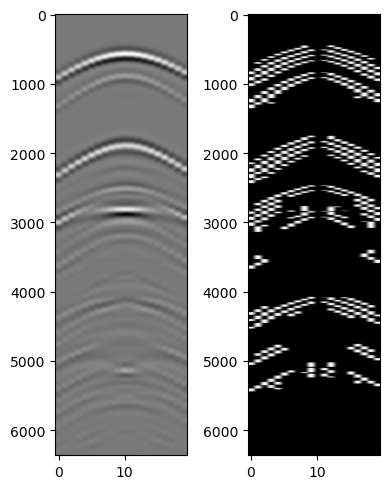

In [ ]:
import cv2
import numpy as np

# Convert the normalized array to a grayscale image (assuming it's in the range 0-255)
image_gray = (Ez * 255).clip(0, 255).astype(np.uint8)

# Apply Canny edge detection
edges = cv2.Canny(image_gray, threshold1 = 50, threshold2 = 100)

# Create the figure and axes objects with the desired size and aspect ratio
fig, ax = plt.subplots(ncols = 2, figsize=(fig_width * 2, fig_height))

# Generate the image
ax[0].imshow(image_gray, cmap='gray', aspect='auto')

ax[1].imshow(edges, cmap='gray', aspect='auto')

# Display the plot
plt.tight_layout()
plt.show()